In [ ]:
import requests
import os
import json
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pprint import pprint
import pytz
import seaborn as sb
import schedule

from datetime import datetime
from datetime import timedelta
from datetime import date
from sklearn.preprocessing import LabelEncoder
import time
from PIL import Image
from IPython.display import display
from concurrent.futures import ThreadPoolExecutor, as_completed

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

pd.options.mode.chained_assignment = None
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, RFE, mutual_info_classif
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import asyncio
import aiohttp
import nest_asyncio

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


In [ ]:
# Standings on December 24th or equivalent

# Define the range of years
start_year = 2000
end_year = 2023
base_url = "https://api-web.nhle.com/v1/standings/"

# Initialize December 23rd dates
december_23_dates = [
    f"{year}-12-24"
    for year in range(start_year, end_year + 1)
    if year not in [2012, 2020]
]

# Initialize DataFrame to store standings data
december_standings = pd.DataFrame()

# Loop through each December 23rd date
for dec_date in december_23_dates:
    api_url = f"{base_url}{dec_date}"
    response = requests.get(api_url)
    if response.status_code == 200:
        response_json = response.json()

        # Normalize standings data (adjust this based on the API response structure)
        if "standings" in response_json:
            standings = response_json["standings"]
            standings_df = pd.json_normalize(standings)

            # Add the December 23rd date to the data
            standings_df["december_date"] = dec_date

            # Concatenate with the main DataFrame
            december_standings = pd.concat(
                [december_standings, standings_df], ignore_index=True
            )
        else:
            print(f"No standings data available for {dec_date}")
    else:
        print(
            f"Failed to retrieve data for {dec_date}, status code: {response.status_code}"
        )


december_standings.head()

,conferenceAbbrev,conferenceHomeSequence,conferenceL10Sequence,conferenceName,conferenceRoadSequence,conferenceSequence,date,divisionAbbrev,divisionHomeSequence,divisionL10Sequence,divisionName,divisionRoadSequence,divisionSequence,gameTypeId,gamesPlayed,goalDifferential,goalDifferentialPctg,goalAgainst,goalFor,goalsForPctg,homeGamesPlayed,homeGoalDifferential,homeGoalsAgainst,homeGoalsFor,homeLosses,homeOtLosses,homePoints,homeRegulationPlusOtWins,homeRegulationWins,homeTies,homeWins,l10GamesPlayed,l10GoalDifferential,l10GoalsAgainst,l10GoalsFor,l10Losses,l10OtLosses,l10Points,l10RegulationPlusOtWins,l10RegulationWins,l10Ties,l10Wins,leagueHomeSequence,leagueL10Sequence,leagueRoadSequence,leagueSequence,losses,otLosses,pointPctg,points,regulationPlusOtWinPctg,regulationPlusOtWins,regulationWinPctg,regulationWins,roadGamesPlayed,roadGoalDifferential,roadGoalsAgainst,roadGoalsFor,roadLosses,roadOtLosses,roadPoints,roadRegulationPlusOtWins,roadRegulationWins,roadTies,roadWins,seasonId,shootoutLosses,shootoutWins,streakCode,streakCount,teamLogo,ties,waiversSequence,wildcardSequence,winPctg,wins,placeName.default,teamName.default,teamName.fr,teamCommonName.default,teamAbbrev.default,teamCommonName.fr,placeName.fr,december_date
0,XVW,1.0,7.0,Western,3.0,1.0,2000-12-24,NW,1.0,2.0,Northwest,1.0,1.0,2.0,35.0,29.0,0.828571,79.0,108.0,3.085714,20.0,18.0,42.0,60.0,3.0,0.0,31.0,14.0,10.0,3.0,14.0,10.0,1.0,28.0,29.0,3.0,0.0,12.0,5.0,4.0,2.0,5.0,1.0,14.0,7.0,1.0,7.0,0.0,0.728571,51.0,0.657143,23.0,0.514286,18.0,15.0,11.0,37.0,48.0,4.0,0.0,20.0,9.0,8.0,2.0,9.0,20002001.0,0.0,0.0,W,2.0,https://assets.nhle.com/logos/nhl/svg/COL_ligh...,5.0,29.0,0.0,0.657143,23.0,Colorado,Colorado Avalanche,Avalanche du Colorado,Avalanche,COL,NaN,NaN,2000-12-24
1,XVW,2.0,1.0,Western,4.0,2.0,2000-12-24,CEN,1.0,1.0,Central,2.0,1.0,2.0,31.0,53.0,1.709677,61.0,114.0,3.677419,16.0,29.0,26.0,55.0,1.0,0.0,28.0,13.0,12.0,2.0,13.0,10.0,25.0,23.0,48.0,0.0,0.0,19.0,9.0,8.0,1.0,9.0,2.0,1.0,3.0,2.0,4.0,0.0,0.806452,50.0,0.741935,23.0,0.677419,21.0,15.0,24.0,35.0,59.0,3.0,0.0,22.0,10.0,9.0,2.0,10.0,20002001.0,0.0,0.0,W,2.0,https://assets.nhle.com/logos/nhl/svg/STL_2000...,4.0,30.0,0.0,0.741935,23.0,St. Louis,St. Louis Blues,Blues de St. Louis,Blues,STL,NaN,NaN,2000-12-24
2,XVW,6.0,6.0,Western,1.0,4.0,2000-12-24,CEN,2.0,2.0,Central,1.0,2.0,2.0,38.0,14.0,0.368421,98.0,112.0,2.947368,21.0,4.0,58.0,62.0,8.0,2.0,23.0,10.0,7.0,1.0,10.0,10.0,3.0,23.0,26.0,3.0,0.0,12.0,5.0,2.0,2.0,5.0,12.0,12.0,1.0,3.0,12.0,2.0,0.618421,47.0,0.552632,21.0,0.421053,16.0,17.0,10.0,40.0,50.0,4.0,0.0,24.0,11.0,9.0,2.0,11.0,20002001.0,0.0,0.0,W,2.0,https://assets.nhle.com/logos/nhl/svg/DET_ligh...,3.0,24.0,0.0,0.552632,21.0,Detroit,Detroit Red Wings,Red Wings de Detroit,Red Wings,DET,NaN,NaN,2000-12-24
3,XVW,7.0,4.0,Western,2.0,3.0,2000-12-24,PAC,2.0,2.0,Pacific,1.0,1.0,2.0,33.0,25.0,0.757576,73.0,98.0,2.969697,15.0,10.0,33.0,43.0,3.0,0.0,22.0,10.0,9.0,2.0,10.0,10.0,6.0,24.0,30.0,3.0,0.0,13.0,6.0,5.0,1.0,6.0,13.0,6.0,2.0,4.0,8.0,0.0,0.696970,46.0,0.636364,21.0,0.545455,18.0,18.0,15.0,40.0,55.0,5.0,0.0,24.0,11.0,9.0,2.0,11.0,20002001.0,0.0,0.0,L,2.0,https://assets.nhle.com/logos/nhl/svg/SJS_1998...,4.0,28.0,0.0,0.636364,21.0,San Jose,San Jose Sharks,Sharks de San Jose,Sharks,SJS,NaN,NaN,2000-12-24
4,XVE,4.0,2.0,Eastern,4.0,1.0,2000-12-24,NE,2.0,1.0,Northeast,2.0,1.0,2.0,34.0,31.0,0.911765,77.0,108.0,3.176471,18.0,17.0,43.0,60.0,4.0,0.0,25.0,11.0,11.0,3.0,11.0,10.0,12.0,19.0,31.0,2.0,0.0,14.0,6.0,6.0,2.0,6.0,5.0,3.0,11.0,5.0,9.0,0.0,0.647059,44.0,0.558824,19.0,0.558824,19.0,16.0,14.0,34.0,48.0,5.0,0.0,19.0,8.0,8.0,3.0,8.0,20002001.0,0.0,0.0,L,1.0,https://assets.nhle.com/logos/nhl/svg/OTT_1997...,6.0,27.0,0.0,0.558824,19.0,Ottawa,Ottawa Senators,Sénateurs d'Ottawa,Senators,OTT,Sénateurs,NaN,2000-12-24


In [6]:
december_standings.shape

(639, 84)

In [ ]:
december_standings["gamesPlayed"].mean()

34.838810641627546

In [ ]:
# 35% of the season in
def lockout_season():
    try:
        api_url = "https://api-web.nhle.com/v1/standings/2013-02-24"
        response = requests.get(api_url)
        content = json.loads(response.content)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # The response content can be accessed using response.text
            response_text = response.text
            # pprint(response_text)
        else:
            print(f"Request failed with status code {response.status_code}")

        json_data = json.loads(response_text)
        standings = json_data["standings"]
        lockout_standings = pd.DataFrame(standings)

        # Extract team names
        lockout_standings["team"] = lockout_standings["teamCommonName"].apply(
            lambda x: x["default"]
        )
        lockout_standings = lockout_standings[
            [
                "conferenceName",
                "conferenceSequence",
                "divisionName",
                "divisionSequence",
                "gamesPlayed",
                "goalDifferential",
                "goalDifferentialPctg",
                "goalAgainst",
                "goalFor",
                "goalsForPctg",
                "pointPctg",
                "points",
                "regulationPlusOtWinPctg",
                "regulationPlusOtWins",
                "regulationWinPctg",
                "regulationWins",
                "streakCode",
                "streakCount",
                "winPctg",
                "team",
            ]
        ]

        # points_per_game = lockout_standings['points'] / lockout_standings['gamesPlayed']
        # games_remaining = 82 - lockout_standings['gamesPlayed']
        # projected_final_points = lockout_standings['points']  + (games_remaining * points_per_game)
        # lockout_standings['projected_points'] = round(projected_final_points)
        # Post-process the standings DataFrame
        if not lockout_standings.empty:
            lockout_standings = lockout_standings.convert_dtypes()
            output_path = r"C:/Users/kjcs2/GitHub/hockey/lockout_christmas.csv"
            lockout_standings.to_csv(output_path, index=False)
            print(f"Thanksgiving standings data saved to {output_path}")

        return lockout_standings
    except Exception as e:
        print(f"Error loading standings data: {e}")
        return None


lockout = lockout_season()

if lockout is not None:
    print(lockout)


else:
    print("No data returned.")

Thanksgiving standings data saved to C:/Users/kjcs2/GitHub/hockey/lockout_christmas.csv
   conferenceName  conferenceSequence divisionName  divisionSequence  \
0         Western                   1      Central                 1   
1         Western                   2      Pacific                 1   
2         Eastern                   1    Northeast                 1   
3         Eastern                   2     Atlantic                 1   
4         Eastern                   4    Northeast                 2   
5         Western                   3    Northwest                 1   
6         Eastern                   5     Atlantic                 2   
7         Eastern                   6    Northeast                 3   
8         Western                   4      Central                 2   
9         Eastern                   7    Northeast                 4   
10        Western                   5      Central                 3   
11        Western                   6      Centr

In [ ]:
def covid_season():
    try:
        api_url = "https://api-web.nhle.com/v1/standings/2021-03-04"
        response = requests.get(api_url)
        content = json.loads(response.content)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # The response content can be accessed using response.text
            response_text = response.text
            # pprint(response_text)
        else:
            print(f"Request failed with status code {response.status_code}")

        json_data = json.loads(response_text)
        standings = json_data["standings"]
        covid_standings = pd.DataFrame(standings)

        # Extract team names
        covid_standings["team"] = covid_standings["teamCommonName"].apply(
            lambda x: x["default"]
        )
        # covid_standings = covid_standings[['conferenceName', 'conferenceSequence', 'divisionName', 'divisionSequence', 'gamesPlayed', 'goalDifferential',
        #                                        'goalDifferentialPctg', 'goalAgainst', 'goalFor', 'goalsForPctg', 'pointPctg', 'points',	'regulationPlusOtWinPctg',
        #                                        'regulationPlusOtWins', 'regulationWinPctg', 'regulationWins', 'streakCode', 'streakCount', 'winPctg', 'team']]

        # points_per_game = lockout_standings['points'] / lockout_standings['gamesPlayed']
        # games_remaining = 82 - lockout_standings['gamesPlayed']
        # projected_final_points = lockout_standings['points']  + (games_remaining * points_per_game)
        # lockout_standings['projected_points'] = round(projected_final_points)
        # Post-process the standings DataFrame
        if not covid_standings.empty:
            covid_standings = covid_standings.convert_dtypes()
            output_path = r"C:/Users/kjcs2/GitHub/hockey/covid_christmas.csv"
            covid_standings.to_csv(output_path, index=False)
            print(f"Thanksgiving standings data saved to {output_path}")

        return covid_standings
    except Exception as e:
        print(f"Error loading standings data: {e}")
        return None


covid = covid_season()

if covid is not None:
    print(covid)


else:
    print("No data returned.")

Thanksgiving standings data saved to C:/Users/kjcs2/GitHub/hockey/covid_christmas.csv
    conferenceHomeSequence  conferenceL10Sequence  conferenceRoadSequence  \
0                        0                      0                       0   
1                        0                      0                       0   
2                        0                      0                       0   
3                        0                      0                       0   
4                        0                      0                       0   
5                        0                      0                       0   
6                        0                      0                       0   
7                        0                      0                       0   
8                        0                      0                       0   
9                        0                      0                       0   
10                       0                      0                  

In [ ]:
# today's standings

api_url = "https://api-web.nhle.com/v1/standings/2024-12-24"
response = requests.get(api_url)
content = json.loads(response.content)


# Check if the request was successful (status code 200)
if response.status_code == 200:
    # The response content can be accessed using response.text
    response_text = response.text
    # pprint(response_text)
else:
    print(f"Request failed with status code {response.status_code}")

json_data = json.loads(response_text)
standings = json_data["standings"]
standings_df = pd.DataFrame(standings)

# Extract team names
standings_df["team_name"] = standings_df["teamName"].apply(lambda x: x["default"])
standings_df["tri_code"] = standings_df["teamAbbrev"].apply(lambda x: x["default"])
standings_df["season_id"] = standings_df["seasonId"]
standings_df["num_teams"] = 32
standings_df = standings_df[
    [
        "conferenceName",
        "leagueSequence",
        "divisionName",
        "gamesPlayed",
        "team_name",
        "tri_code",
        "winPctg",
        "conferenceSequence",
        "date",
        "divisionSequence",
        "points",
        "regulationWins",
        "regulationPlusOtWins",
        "pointPctg",
        "goalDifferential",
        "goalDifferentialPctg",
        "goalFor",
        "season_id",
        "num_teams",
    ]
]

points_per_game = standings_df["points"] / standings_df["gamesPlayed"]
games_remaining = 82 - standings_df["gamesPlayed"]
projected_final_points = standings_df["points"] + (games_remaining * points_per_game)
standings_df["projected_points"] = round(projected_final_points)
current_standings = standings_df
current_standings.head()


,conferenceName,leagueSequence,divisionName,gamesPlayed,team_name,tri_code,winPctg,conferenceSequence,date,divisionSequence,points,regulationWins,regulationPlusOtWins,pointPctg,goalDifferential,goalDifferentialPctg,goalFor,season_id,num_teams,projected_points
0,Western,1,Central,36,Winnipeg Jets,WPG,0.694444,1,2024-12-24,1,51,21,25,0.708333,44,1.222222,133,20242025,32,116.0
1,Western,2,Pacific,34,Vegas Golden Knights,VGK,0.676471,2,2024-12-24,1,49,20,22,0.720588,24,0.705882,120,20242025,32,118.0
2,Eastern,3,Metropolitan,37,New Jersey Devils,NJD,0.621622,1,2024-12-24,1,49,22,23,0.662162,33,0.891892,124,20242025,32,109.0
3,Eastern,4,Metropolitan,34,Washington Capitals,WSH,0.676471,2,2024-12-24,2,48,20,23,0.705882,36,1.058824,125,20242025,32,116.0
4,Western,5,Central,35,Minnesota Wild,MIN,0.600000,3,2024-12-24,2,46,17,20,0.657143,8,0.228571,104,20242025,32,108.0


In [ ]:
december_standings["gamesPlayed"].mean()

34.838810641627546

In [ ]:
# Season End Dates
# Dictionary of seasons and corresponding end dates
nhl_season_dates = {
    "20002001": "2001-04-08",
    "20012002": "2002-04-14",
    "20022003": "2003-04-06",
    "20032004": "2004-04-04",
    "20052006": "2006-04-18",
    "20062007": "2007-04-08",
    "20072008": "2008-04-06",
    "20082009": "2009-04-12",
    "20092010": "2010-04-11",
    "20102011": "2011-04-10",
    "20112012": "2012-04-07",
    "20122013": "2013-04-27",
    "20132014": "2014-04-13",
    "20142015": "2015-04-11",
    "20152016": "2016-04-10",
    "20162017": "2017-04-09",
    "20172018": "2018-04-08",
    "20182019": "2019-04-06",
    "20192020": "2020-03-12",
    "20202021": "2021-05-19",
    "20212022": "2022-04-29",
    "20222023": "2023-04-13",
    "20232024": "2024-04-18",
}


def final_standings(season_dates):
    try:
        base_url = "https://api-web.nhle.com/v1/standings/"

        # Initialize DataFrame to store all standings data
        final_standings_all = pd.DataFrame()

        # Loop through each season and its end date
        for season_id, end_date in season_dates.items():
            api_url = f"{base_url}{end_date}"
            response = requests.get(api_url)

            if response.status_code == 200:
                response_json = response.json()

                # Check if standings data exists
                if "standings" in response_json:
                    final = response_json["standings"]
                    final_df = pd.json_normalize(final)

                    # Add season ID and end date to the data
                    final_df["season_id"] = season_id
                    final_df["end_date"] = end_date

                    # Concatenate with the main DataFrame
                    final_standings_all = pd.concat(
                        [final_standings_all, final_df], ignore_index=True
                    )
                else:
                    print(f"No standings data available for {end_date}")
            else:
                print(
                    f"Failed to retrieve data for {end_date}, status code: {response.status_code}"
                )

        # Save the DataFrame to a CSV file
        final_standings_all.to_csv("final_standings_all.csv", index=False)
        print("Data saved to 'final_standings_all.csv'.")

        return final_standings_all

    except Exception as e:
        print(f"Error loading final standings: {e}")
        return pd.DataFrame()


# Run the function and store the result
finals = final_standings(nhl_season_dates)

# Load the DataFrame later
final_standings_all_loaded = pd.read_csv("final_standings_all.csv")

# Display the loaded DataFrame
if not final_standings_all_loaded.empty:
    print(final_standings_all_loaded.head())
else:
    print("No data found in the saved file.")


Data saved to 'final_standings_all.csv'.
  clinchIndicator conferenceAbbrev  conferenceHomeSequence  \
0               p              XVW                     2.0   
1               y              XVW                     4.0   
2               z              XVE                     5.0   
3               y              XVE                     1.0   
4               y              XVW                     3.0   

   conferenceL10Sequence conferenceName  conferenceRoadSequence  \
0                    3.0        Western                     1.0   
1                    2.0        Western                     2.0   
2                    1.0        Eastern                     1.0   
3                    2.0        Eastern                     2.0   
4                    1.0        Western                     3.0   

   conferenceSequence        date divisionAbbrev  divisionHomeSequence  \
0                 1.0  2001-04-08             NW                   1.0   
1                 2.0  2001-04-08  

In [ ]:
final_standings_all_loaded = final_standings_all_loaded[
    [
        "conferenceName",
        "conferenceSequence",
        "divisionName",
        "divisionSequence",
        "goalDifferential",
        "goalDifferentialPctg",
        "goalAgainst",
        "goalFor",
        "goalsForPctg",
        "wins",
        "losses",
        "pointPctg",
        "points",
        "winPctg",
        "teamName.default",
        "streakCode",
        "streakCount",
        "season_id",
    ]
]
final_standings_all_loaded.head()

,conferenceName,conferenceSequence,divisionName,divisionSequence,goalDifferential,goalDifferentialPctg,goalAgainst,goalFor,goalsForPctg,wins,losses,pointPctg,points,winPctg,teamName.default,streakCode,streakCount,season_id
0,Western,1.0,Northwest,1.0,78.0,0.951220,192.0,270.0,3.292683,52.0,16.0,0.719512,118.0,0.634146,Colorado Avalanche,W,1.0,20002001
1,Western,2.0,Central,1.0,51.0,0.621951,202.0,253.0,3.085366,49.0,20.0,0.676829,111.0,0.597561,Detroit Red Wings,W,2.0,20002001
2,Eastern,1.0,Atlantic,1.0,100.0,1.219512,195.0,295.0,3.597561,48.0,19.0,0.676829,111.0,0.585366,New Jersey Devils,W,4.0,20002001
3,Eastern,2.0,Northeast,1.0,69.0,0.841463,205.0,274.0,3.341463,48.0,21.0,0.664634,109.0,0.585366,Ottawa Senators,W,2.0,20002001
4,Western,3.0,Pacific,1.0,54.0,0.658537,187.0,241.0,2.939024,48.0,24.0,0.646341,106.0,0.585366,Dallas Stars,W,2.0,20002001


In [ ]:
december_standings = december_standings.rename(columns={"seasondId": "season_id"})


In [ ]:
december_standings["season_id"] = december_standings["seasonId"]

In [ ]:
# Ensure both DataFrames have the necessary columns
if (
    "teamName.default" in december_standings.columns
    and "teamName.default" in final_standings_all_loaded.columns
):
    # Perform the merge on teamName.default and season_id
    christmas_predictions = december_standings.merge(
        final_standings_all_loaded,
        on=["teamName.default", "season_id"],  # Specify the columns to merge on
        how="inner",  # Choose the merge type (inner, left, right, outer)
    )

    # Display the merged DataFrame
    christmas_predictions.head()
else:
    print("The required columns for merging are missing in one or both DataFrames.")


In [17]:
christmas_predictions.head()

,conferenceAbbrev,conferenceHomeSequence,conferenceL10Sequence,conferenceName_x,conferenceRoadSequence,conferenceSequence_x,date,divisionAbbrev,divisionHomeSequence,divisionL10Sequence,divisionName_x,divisionRoadSequence,divisionSequence_x,gameTypeId,gamesPlayed,goalDifferential_x,goalDifferentialPctg_x,goalAgainst_x,goalFor_x,goalsForPctg_x,homeGamesPlayed,homeGoalDifferential,homeGoalsAgainst,homeGoalsFor,homeLosses,homeOtLosses,homePoints,homeRegulationPlusOtWins,homeRegulationWins,homeTies,homeWins,l10GamesPlayed,l10GoalDifferential,l10GoalsAgainst,l10GoalsFor,l10Losses,l10OtLosses,l10Points,l10RegulationPlusOtWins,l10RegulationWins,l10Ties,l10Wins,leagueHomeSequence,leagueL10Sequence,leagueRoadSequence,leagueSequence,losses_x,otLosses,pointPctg_x,points_x,regulationPlusOtWinPctg,regulationPlusOtWins,regulationWinPctg,regulationWins,roadGamesPlayed,roadGoalDifferential,roadGoalsAgainst,roadGoalsFor,roadLosses,roadOtLosses,roadPoints,roadRegulationPlusOtWins,roadRegulationWins,roadTies,roadWins,seasonId,shootoutLosses,shootoutWins,streakCode_x,streakCount_x,teamLogo,ties,waiversSequence,wildcardSequence,winPctg_x,wins_x,placeName.default,teamName.default,teamName.fr,teamCommonName.default,teamAbbrev.default,teamCommonName.fr,placeName.fr,december_date,season_id,conferenceName_y,conferenceSequence_y,divisionName_y,divisionSequence_y,goalDifferential_y,goalDifferentialPctg_y,goalAgainst_y,goalFor_y,goalsForPctg_y,wins_y,losses_y,pointPctg_y,points_y,winPctg_y,streakCode_y,streakCount_y
0,XVW,1.0,7.0,Western,3.0,1.0,2000-12-24,NW,1.0,2.0,Northwest,1.0,1.0,2.0,35.0,29.0,0.828571,79.0,108.0,3.085714,20.0,18.0,42.0,60.0,3.0,0.0,31.0,14.0,10.0,3.0,14.0,10.0,1.0,28.0,29.0,3.0,0.0,12.0,5.0,4.0,2.0,5.0,1.0,14.0,7.0,1.0,7.0,0.0,0.728571,51.0,0.657143,23.0,0.514286,18.0,15.0,11.0,37.0,48.0,4.0,0.0,20.0,9.0,8.0,2.0,9.0,20002001.0,0.0,0.0,W,2.0,https://assets.nhle.com/logos/nhl/svg/COL_ligh...,5.0,29.0,0.0,0.657143,23.0,Colorado,Colorado Avalanche,Avalanche du Colorado,Avalanche,COL,NaN,NaN,2000-12-24,20002001.0,Western,1.0,Northwest,1.0,78.0,0.951220,192.0,270.0,3.292683,52.0,16.0,0.719512,118.0,0.634146,W,1.0
1,XVW,2.0,1.0,Western,4.0,2.0,2000-12-24,CEN,1.0,1.0,Central,2.0,1.0,2.0,31.0,53.0,1.709677,61.0,114.0,3.677419,16.0,29.0,26.0,55.0,1.0,0.0,28.0,13.0,12.0,2.0,13.0,10.0,25.0,23.0,48.0,0.0,0.0,19.0,9.0,8.0,1.0,9.0,2.0,1.0,3.0,2.0,4.0,0.0,0.806452,50.0,0.741935,23.0,0.677419,21.0,15.0,24.0,35.0,59.0,3.0,0.0,22.0,10.0,9.0,2.0,10.0,20002001.0,0.0,0.0,W,2.0,https://assets.nhle.com/logos/nhl/svg/STL_2000...,4.0,30.0,0.0,0.741935,23.0,St. Louis,St. Louis Blues,Blues de St. Louis,Blues,STL,NaN,NaN,2000-12-24,20002001.0,Western,4.0,Central,2.0,54.0,0.658537,195.0,249.0,3.036585,43.0,22.0,0.628049,103.0,0.524390,W,2.0
2,XVW,6.0,6.0,Western,1.0,4.0,2000-12-24,CEN,2.0,2.0,Central,1.0,2.0,2.0,38.0,14.0,0.368421,98.0,112.0,2.947368,21.0,4.0,58.0,62.0,8.0,2.0,23.0,10.0,7.0,1.0,10.0,10.0,3.0,23.0,26.0,3.0,0.0,12.0,5.0,2.0,2.0,5.0,12.0,12.0,1.0,3.0,12.0,2.0,0.618421,47.0,0.552632,21.0,0.421053,16.0,17.0,10.0,40.0,50.0,4.0,0.0,24.0,11.0,9.0,2.0,11.0,20002001.0,0.0,0.0,W,2.0,https://assets.nhle.com/logos/nhl/svg/DET_ligh...,3.0,24.0,0.0,0.552632,21.0,Detroit,Detroit Red Wings,Red Wings de Detroit,Red Wings,DET,NaN,NaN,2000-12-24,20002001.0,Western,2.0,Central,1.0,51.0,0.621951,202.0,253.0,3.085366,49.0,20.0,0.676829,111.0,0.597561,W,2.0
3,XVW,7.0,4.0,Western,2.0,3.0,2000-12-24,PAC,2.0,2.0,Pacific,1.0,1.0,2.0,33.0,25.0,0.757576,73.0,98.0,2.969697,15.0,10.0,33.0,43.0,3.0,0.0,22.0,10.0,9.0,2.0,10.0,10.0,6.0,24.0,30.0,3.0,0.0,13.0,6.0,5.0,1.0,6.0,13.0,6.0,2.0,4.0,8.0,0.0,0.696970,46.0,0.636364,21.0,0.545455,18.0,18.0,15.0,40.0,55.0,5.0,0.0,24.0,11.0,9.0,2.0,11.0,20002001.0,0.0,0.0,L,2.0,https://assets.nhle.com/logos/nhl/svg/SJS_1998...,4.0,28.0,0.0,0.636364,21.0,San Jose,San Jose Sharks,Sharks de San Jose,Sharks,SJS,NaN,NaN,2000-12-24,20002001.0,Western,5.0,Pacific,2.0,25.0,0.304878,192.0,217.0,2.646341,40.0,27.0,0.579268,95.0,0.487805,W,1.0
4,XVE,4.0,2

In [ ]:
christmas_clean = christmas_predictions[
    [
        "season_id",
        "conferenceName_x",
        "conferenceSequence_x",
        "gamesPlayed",
        "goalDifferential_x",
        "goalDifferentialPctg_x",
        "goalAgainst_x",
        "goalFor_x",
        "goalsForPctg_x",
        "pointPctg_x",
        "points_x",
        "streakCode_x",
        "streakCount_x",
        "winPctg_x",
        "teamName.default",
        "teamAbbrev.default",
        "conferenceSequence_y",
        "goalDifferential_y",
        "goalDifferentialPctg_y",
        "goalAgainst_y",
        "goalFor_y",
        "goalsForPctg_y",
        "pointPctg_y",
        "points_y",
        "winPctg_y",
        "streakCode_y",
        "streakCount_y",
    ]
]
christmas_clean.head()

,season_id,conferenceName_x,conferenceSequence_x,gamesPlayed,goalDifferential_x,goalDifferentialPctg_x,goalAgainst_x,goalFor_x,goalsForPctg_x,pointPctg_x,points_x,streakCode_x,streakCount_x,winPctg_x,teamName.default,teamAbbrev.default,conferenceSequence_y,goalDifferential_y,goalDifferentialPctg_y,goalAgainst_y,goalFor_y,goalsForPctg_y,pointPctg_y,points_y,winPctg_y,streakCode_y,streakCount_y
0,20002001.0,Western,1.0,35.0,29.0,0.828571,79.0,108.0,3.085714,0.728571,51.0,W,2.0,0.657143,Colorado Avalanche,COL,1.0,78.0,0.951220,192.0,270.0,3.292683,0.719512,118.0,0.634146,W,1.0
1,20002001.0,Western,2.0,31.0,53.0,1.709677,61.0,114.0,3.677419,0.806452,50.0,W,2.0,0.741935,St. Louis Blues,STL,4.0,54.0,0.658537,195.0,249.0,3.036585,0.628049,103.0,0.524390,W,2.0
2,20002001.0,Western,4.0,38.0,14.0,0.368421,98.0,112.0,2.947368,0.618421,47.0,W,2.0,0.552632,Detroit Red Wings,DET,2.0,51.0,0.621951,202.0,253.0,3.085366,0.676829,111.0,0.597561,W,2.0
3,20002001.0,Western,3.0,33.0,25.0,0.757576,73.0,98.0,2.969697,0.696970,46.0,L,2.0,0.636364,San Jose Sharks,SJS,5.0,25.0,0.304878,192.0,217.0,2.646341,0.579268,95.0,0.487805,W,1.0
4,20002001.0,Eastern,1.0,34.0,31.0,0.911765,77.0,108.0,3.176471,0.647059,44.0,L,1.0,0.558824,Ottawa Senators,OTT,2.0,69.0,0.841463,205.0,274.0,3.341463,0.664634,109.0,0.585366,W,2.0


In [ ]:
christmas_clean = christmas_clean.rename(
    columns={
        "conferenceName_x": "conference",
        "conferenceSequence_x": "christmas",
        "conferenceSequence_y": "season_end",
        "goalDifferential_x": "tx_goal_diff",
        "goalDifferential_y": "end_goal_diff",
        "goalDifferentialPctg_x": "tx_goal_diff_pct",
        "goalDifferentialPctg_y": "end_goal_diff_pct",
        "goalAgainst_x": "tx_GA",
        "goalAgainst_y": "end_GA",
        "goalFor_x": "tx_GF",
        "goalFor_y": "end_GF",
        "goalsForPctg_x": "tx_gf_pctg",
        "goalsForPctg_y": "end_gf_pctg",
        "points_x": "tx_points",
        "points_y": "end_points",
        "pointPctg_x": "tx_points_pct",
        "pointPctg_y": "end_points_pct",
        "streakCode_x": "tx_streak_code",
        "streakCount_x": "tx_streak_count",
        "streakCode_y": "end_streak_code",
        "streakCount_y": "end_streak_count",
        "winPctg_x": "tx_win_pctg",
        "winPctg_y": "end_win_pctg",
        "teamName.default": "team_name",
        "teamAbbrev.default": "tri_code",
    }
)
christmas_clean.head()

,season_id,conference,christmas,gamesPlayed,tx_goal_diff,tx_goal_diff_pct,tx_GA,tx_GF,tx_gf_pctg,tx_points_pct,tx_points,tx_streak_code,tx_streak_count,tx_win_pctg,team_name,tri_code,season_end,end_goal_diff,end_goal_diff_pct,end_GA,end_GF,end_gf_pctg,end_points_pct,end_points,end_win_pctg,end_streak_code,end_streak_count
0,20002001.0,Western,1.0,35.0,29.0,0.828571,79.0,108.0,3.085714,0.728571,51.0,W,2.0,0.657143,Colorado Avalanche,COL,1.0,78.0,0.951220,192.0,270.0,3.292683,0.719512,118.0,0.634146,W,1.0
1,20002001.0,Western,2.0,31.0,53.0,1.709677,61.0,114.0,3.677419,0.806452,50.0,W,2.0,0.741935,St. Louis Blues,STL,4.0,54.0,0.658537,195.0,249.0,3.036585,0.628049,103.0,0.524390,W,2.0
2,20002001.0,Western,4.0,38.0,14.0,0.368421,98.0,112.0,2.947368,0.618421,47.0,W,2.0,0.552632,Detroit Red Wings,DET,2.0,51.0,0.621951,202.0,253.0,3.085366,0.676829,111.0,0.597561,W,2.0
3,20002001.0,Western,3.0,33.0,25.0,0.757576,73.0,98.0,2.969697,0.696970,46.0,L,2.0,0.636364,San Jose Sharks,SJS,5.0,25.0,0.304878,192.0,217.0,2.646341,0.579268,95.0,0.487805,W,1.0
4,20002001.0,Eastern,1.0,34.0,31.0,0.911765,77.0,108.0,3.176471,0.647059,44.0,L,1.0,0.558824,Ottawa Senators,OTT,2.0,69.0,0.841463,205.0,274.0,3.341463,0.664634,109.0,0.585366,W,2.0


In [ ]:
christmas_clean["goal_diff_pct_change"] = (
    christmas_clean["tx_goal_diff_pct"] - christmas_clean["end_goal_diff_pct"]
)

In [ ]:
christmas_clean["season_id"] = christmas_clean["season_id"].fillna(0).astype("int64")
christmas_clean["season_end"] = christmas_clean["season_end"].fillna(0).astype("int64")

In [ ]:
christmas_clean["status_a"] = np.where(christmas_clean["christmas"] < 9, 1, 0)
christmas_clean["status_b"] = np.where(christmas_clean["season_end"] < 9, 1, 0)
christmas_clean.head()

,season_id,conference,christmas,gamesPlayed,tx_goal_diff,tx_goal_diff_pct,tx_GA,tx_GF,tx_gf_pctg,tx_points_pct,tx_points,tx_streak_code,tx_streak_count,tx_win_pctg,team_name,tri_code,season_end,end_goal_diff,end_goal_diff_pct,end_GA,end_GF,end_gf_pctg,end_points_pct,end_points,end_win_pctg,end_streak_code,end_streak_count,goal_diff_pct_change,status_a,status_b
0,20002001,Western,1.0,35.0,29.0,0.828571,79.0,108.0,3.085714,0.728571,51.0,W,2.0,0.657143,Colorado Avalanche,COL,1,78.0,0.951220,192.0,270.0,3.292683,0.719512,118.0,0.634146,W,1.0,-0.122649,1,1
1,20002001,Western,2.0,31.0,53.0,1.709677,61.0,114.0,3.677419,0.806452,50.0,W,2.0,0.741935,St. Louis Blues,STL,4,54.0,0.658537,195.0,249.0,3.036585,0.628049,103.0,0.524390,W,2.0,1.051140,1,1
2,20002001,Western,4.0,38.0,14.0,0.368421,98.0,112.0,2.947368,0.618421,47.0,W,2.0,0.552632,Detroit Red Wings,DET,2,51.0,0.621951,202.0,253.0,3.085366,0.676829,111.0,0.597561,W,2.0,-0.253530,1,1
3,20002001,Western,3.0,33.0,25.0,0.757576,73.0,98.0,2.969697,0.696970,46.0,L,2.0,0.636364,San Jose Sharks,SJS,5,25.0,0.304878,192.0,217.0,2.646341,0.579268,95.0,0.487805,W,1.0,0.452698,1,1
4,20002001,Eastern,1.0,34.0,31.0,0.911765,77.0,108.0,3.176471,0.647059,44.0,L,1.0,0.558824,Ottawa Senators,OTT,2,69.0,0.841463,205.0,274.0,3.341463,0.664634,109.0,0.585366,W,2.0,0.070302,1,1


In [ ]:
# Filter teams in playoff position at Thanksgiving
playoff_at_xmas = christmas_clean[christmas_clean["status_a"] == 1]

# Calculate odds of making playoffs
odds = playoff_at_xmas["status_b"].mean()  # Mean gives the proportion of 1s

print(f"Odds of making playoffs if in playoff position at Thanksgiving: {odds:.2%}")


Odds of making playoffs if in playoff position at Thanksgiving: 80.31%


In [ ]:
# is there a difference between the conferences?
conference_odds = playoff_at_xmas.groupby("conference")["status_b"].mean()
print(conference_odds)


conference
Eastern    0.80625
Western    0.80000
Name: status_b, dtype: float64


In [ ]:
# Filter teams not in playoff position at Thanksgiving but made playoffs
late_surge_teams = christmas_clean[
    (christmas_clean["status_a"] == 0) & (christmas_clean["status_b"] == 1)
]
drop_out_teams = christmas_clean[
    (christmas_clean["status_a"] == 1) & (christmas_clean["status_b"] == 0)
]
# Calculate distance to 8th spot (positive values indicate better positioning)
late_surge_teams["distance_to_8th"] = 8 - late_surge_teams["christmas"]


# Summary statistics on how close they were
avg_distance = late_surge_teams["distance_to_8th"].mean()
median_distance = late_surge_teams["distance_to_8th"].median()
min_distance = late_surge_teams["distance_to_8th"].min()
mean_change_in_goal_diff = late_surge_teams["goal_diff_pct_change"].mean()

print(f"Average distance to 8th spot: {avg_distance:.2f}")
print(f"Median distance to 8th spot: {median_distance:.2f}")
print(f"Closest team to 8th spot: {min_distance:.2f}")
print(f"Avg change in goal diff percentage: {mean_change_in_goal_diff:.2f}")


Average distance to 8th spot: -2.79
Median distance to 8th spot: -2.00
Closest team to 8th spot: -7.00
Avg change in goal diff percentage: -0.35


In [26]:
drop_out_teams.head()

,season_id,conference,christmas,gamesPlayed,tx_goal_diff,tx_goal_diff_pct,tx_GA,tx_GF,tx_gf_pctg,tx_points_pct,tx_points,tx_streak_code,tx_streak_count,tx_win_pctg,team_name,tri_code,season_end,end_goal_diff,end_goal_diff_pct,end_GA,end_GF,end_gf_pctg,end_points_pct,end_points,end_win_pctg,end_streak_code,end_streak_count,goal_diff_pct_change,status_a,status_b
8,20002001,Western,7.0,33.0,15.0,0.454545,72.0,87.0,2.636364,0.621212,41.0,W,2.0,0.484848,Phoenix Coyotes,PHX,9,2.0,0.024390,212.0,214.0,2.609756,0.548780,90.0,0.426829,W,1.0,0.430155,1,0
16,20002001,Eastern,8.0,36.0,-8.0,-0.222222,132.0,124.0,3.444444,0.472222,34.0,OT,1.0,0.444444,New York Rangers,NYR,10,-40.0,-0.487805,290.0,250.0,3.048780,0.439024,72.0,0.402439,L,1.0,0.265583,1,0
35,20012002,Western,5.0,38.0,11.0,0.289474,87.0,98.0,2.578947,0.592105,45.0,L,1.0,0.500000,Edmonton Oilers,EDM,9,23.0,0.280488,182.0,205.0,2.500000,0.560976,92.0,0.463415,W,1.0,0.008986,1,0
36,20012002,Eastern,2.0,39.0,3.0,0.076923,108.0,111.0,2.846154,0.576923,45.0,W,1.0,0.512821,New York Rangers,NYR,11,-31.0,-0.378049,258.0,227.0,2.768293,0.487805,80.0,0.439024,L,2.0,0.454972,1,0
42,20012002,Western,7.0,36.0,8.0,0.222222,96.0,104.0,2.888889,0.569444,41.0,W,2.0,0.444444,Dallas Stars,DAL,10,2.0,0.024390,213.0,215.0,2.621951,0.548780,90.0,0.439024,T,1.0,0.197832,1,0


In [27]:
christmas_clean.head()

,season_id,conference,christmas,gamesPlayed,tx_goal_diff,tx_goal_diff_pct,tx_GA,tx_GF,tx_gf_pctg,tx_points_pct,tx_points,tx_streak_code,tx_streak_count,tx_win_pctg,team_name,tri_code,season_end,end_goal_diff,end_goal_diff_pct,end_GA,end_GF,end_gf_pctg,end_points_pct,end_points,end_win_pctg,end_streak_code,end_streak_count,goal_diff_pct_change,status_a,status_b
0,20002001,Western,1.0,35.0,29.0,0.828571,79.0,108.0,3.085714,0.728571,51.0,W,2.0,0.657143,Colorado Avalanche,COL,1,78.0,0.951220,192.0,270.0,3.292683,0.719512,118.0,0.634146,W,1.0,-0.122649,1,1
1,20002001,Western,2.0,31.0,53.0,1.709677,61.0,114.0,3.677419,0.806452,50.0,W,2.0,0.741935,St. Louis Blues,STL,4,54.0,0.658537,195.0,249.0,3.036585,0.628049,103.0,0.524390,W,2.0,1.051140,1,1
2,20002001,Western,4.0,38.0,14.0,0.368421,98.0,112.0,2.947368,0.618421,47.0,W,2.0,0.552632,Detroit Red Wings,DET,2,51.0,0.621951,202.0,253.0,3.085366,0.676829,111.0,0.597561,W,2.0,-0.253530,1,1
3,20002001,Western,3.0,33.0,25.0,0.757576,73.0,98.0,2.969697,0.696970,46.0,L,2.0,0.636364,San Jose Sharks,SJS,5,25.0,0.304878,192.0,217.0,2.646341,0.579268,95.0,0.487805,W,1.0,0.452698,1,1
4,20002001,Eastern,1.0,34.0,31.0,0.911765,77.0,108.0,3.176471,0.647059,44.0,L,1.0,0.558824,Ottawa Senators,OTT,2,69.0,0.841463,205.0,274.0,3.341463,0.664634,109.0,0.585366,W,2.0,0.070302,1,1


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Apply one-hot encoding to the 'conference' column
X = christmas_clean[["tx_points", "tx_points_pct", "tx_goal_diff", "christmas"]]
X = pd.get_dummies(X, drop_first=True)

# Add the encoded 'conference' column
X["conference"] = christmas_clean["conference"].map({"eastern": 0, "western": 1})

# Define target
y = christmas_clean["status_b"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the random forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature importance
importances = rf.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")


              precision    recall  f1-score   support

           0       0.70      0.70      0.70        57
           1       0.74      0.74      0.74        65

    accuracy                           0.72       122
   macro avg       0.72      0.72      0.72       122
weighted avg       0.72      0.72      0.72       122

tx_points: 0.2058
tx_points_pct: 0.3094
tx_goal_diff: 0.2715
christmas: 0.2134
conference: 0.0000


: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Create streak features
def calculate_streak(row, streak_code_col):
    """
    Calculates the streak value based on the streak code column provided.
    W = 1, L = -1, and other cases will be 0 (or missing streak).
    """
    if row[streak_code_col] == "W":
        return 1  # Win streak is positive
    elif row[streak_code_col] == "L":
        return -1  # Loss streak is negative
    else:
        return 0  # Handle cases where streak data might be missing or undefined


# Apply the function to calculate Thanksgiving streak
christmas_clean["xmas_streak"] = christmas_clean.apply(
    calculate_streak, axis=1, streak_code_col="tx_streak_code"
)

# Apply the function to calculate Season-end streak
christmas_clean["season_end_streak"] = christmas_clean.apply(
    calculate_streak, axis=1, streak_code_col="end_streak_code"
)

# Drop the original streak columns (optional)
christmas_clean = christmas_clean.drop(columns=["tx_streak_code", "end_streak_code"])

# Check the result
christmas_clean.head()


,season_id,conference,christmas,gamesPlayed,tx_goal_diff,tx_goal_diff_pct,tx_GA,tx_GF,tx_gf_pctg,tx_points_pct,tx_points,tx_streak_count,tx_win_pctg,team_name,tri_code,season_end,end_goal_diff,end_goal_diff_pct,end_GA,end_GF,end_gf_pctg,end_points_pct,end_points,end_win_pctg,end_streak_count,goal_diff_pct_change,status_a,status_b,xmas_streak,season_end_streak
0,20002001,Western,1.0,35.0,29.0,0.828571,79.0,108.0,3.085714,0.728571,51.0,2.0,0.657143,Colorado Avalanche,COL,1,78.0,0.951220,192.0,270.0,3.292683,0.719512,118.0,0.634146,1.0,-0.122649,1,1,1,1
1,20002001,Western,2.0,31.0,53.0,1.709677,61.0,114.0,3.677419,0.806452,50.0,2.0,0.741935,St. Louis Blues,STL,4,54.0,0.658537,195.0,249.0,3.036585,0.628049,103.0,0.524390,2.0,1.051140,1,1,1,1
2,20002001,Western,4.0,38.0,14.0,0.368421,98.0,112.0,2.947368,0.618421,47.0,2.0,0.552632,Detroit Red Wings,DET,2,51.0,0.621951,202.0,253.0,3.085366,0.676829,111.0,0.597561,2.0,-0.253530,1,1,1,1
3,20002001,Western,3.0,33.0,25.0,0.757576,73.0,98.0,2.969697,0.696970,46.0,2.0,0.636364,San Jose Sharks,SJS,5,25.0,0.304878,192.0,217.0,2.646341,0.579268,95.0,0.487805,1.0,0.452698,1,1,-1,1
4,20002001,Eastern,1.0,34.0,31.0,0.911765,77.0,108.0,3.176471,0.647059,44.0,1.0,0.558824,Ottawa Senators,OTT,2,69.0,0.841463,205.0,274.0,3.341463,0.664634,109.0,0.585366,2.0,0.070302,1,1,-1,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import xgboost as xgb
from sklearn.metrics import classification_report

# Example of applying one-hot encoding to categorical features (including 'conference')
X = christmas_clean[
    ["tx_points", "tx_points_pct", "tx_goal_diff", "christmas", "conference"]
]
X = pd.get_dummies(X, drop_first=True)

# Define target
y = christmas_clean["status_b"]  # 1 if made playoffs, 0 otherwise

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Feature importance
importances = xgb_model.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")


              precision    recall  f1-score   support

           0       0.71      0.70      0.71        57
           1       0.74      0.75      0.75        65

    accuracy                           0.73       122
   macro avg       0.73      0.73      0.73       122
weighted avg       0.73      0.73      0.73       122

tx_points: 0.1373
tx_points_pct: 0.4507
tx_goal_diff: 0.1739
christmas: 0.1316
conference_Western: 0.1065


: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Assuming 'thanksgiving_clean' has columns 'teamName' and 'season_end_winPctg' for season-end points percentage

team_strength = {}

# Iterate through the DataFrame to create the team_strength dictionary
for _, row in christmas_clean.iterrows():
    team_name = row["team_name"]  # Team name
    win_pctg = row["end_win_pctg"]  # Season-end win percentage (points percentage)

    # Store the team's strength in the dictionary
    team_strength[team_name] = win_pctg

# Check the result
team_strength


{'Colorado Avalanche': 0.609756,
 'St. Louis Blues': 0.52439,
 'Detroit Red Wings': 0.5,
 'San Jose Sharks': 0.231707,
 'Ottawa Senators': 0.45122,
 'Dallas Stars': 0.634146,
 'Toronto Maple Leafs': 0.560976,
 'Vancouver Canucks': 0.609756,
 'Phoenix Coyotes': 0.45122,
 'New Jersey Devils': 0.463415,
 'Buffalo Sabres': 0.47561,
 'Edmonton Oilers': 0.597561,
 'Philadelphia Flyers': 0.463415,
 'Los Angeles Kings': 0.536585,
 'Washington Capitals': 0.487805,
 'Pittsburgh Penguins': 0.463415,
 'New York Rangers': 0.670732,
 'Anaheim Ducks': 0.329268,
 'Atlanta Thrashers': 0.414634,
 'Nashville Predators': 0.573171,
 'Calgary Flames': 0.463415,
 'Boston Bruins': 0.573171,
 'Carolina Hurricanes': 0.634146,
 'Chicago Blackhawks': 0.280488,
 'Minnesota Wild': 0.47561,
 'Columbus Blue Jackets': 0.329268,
 'Tampa Bay Lightning': 0.54878,
 'New York Islanders': 0.47561,
 'Florida Panthers': 0.634146,
 'Montréal Canadiens': 0.365854,
 'Winnipeg Jets': 0.634146,
 'Arizona Coyotes': 0.439024,
 'Vega

In [ ]:
# get games this season

# Initialize the DataFrame
daily_games = pd.DataFrame()

base_url = "https://api-web.nhle.com/v1/schedule/"
# start_date = datetime.strptime("2023-10-09", "%Y-%m-%d")
# end_date = datetime.strptime("2024-04-17", "%Y-%m-%d")

start_date = datetime.strptime("2024-10-04", "%Y-%m-%d")
end_date = datetime.strptime("2024-12-24", "%Y-%m-%d")


current_date = start_date

# Set to keep track of unique dates
seen_dates = set()

while current_date <= end_date:
    # Format the date as 'YYYY-MM-DD'
    formatted_date = current_date.strftime("%Y-%m-%d")
    api_url = f"{base_url}{formatted_date}"

    # Make the API request
    response = requests.get(api_url)

    if response.status_code == 200:
        # The response content can be accessed using response.text
        response_text = response.text
    # pprint(response_text)
    else:
        print(f"Request failed with status code {response.status_code}")

    json_data = json.loads(response_text)

    game_week = json_data["gameWeek"]
    game_week_df = pd.DataFrame(game_week)

    game_week_df = game_week_df[game_week_df["numberOfGames"] != 0]

    # Filter out rows with duplicate dates
    if formatted_date not in seen_dates:
        seen_dates.add(formatted_date)
        daily_games = pd.concat([daily_games, game_week_df], ignore_index=True)
    else:
        print(f"Failed to retrieve data for {formatted_date}")

    # Move to the next week
    current_date += timedelta(weeks=1)
    # Filter out rows where 'date' is after the end date
    daily_games["date"] = pd.to_datetime(daily_games["date"])
    daily_games = daily_games[daily_games["date"] <= end_date]

    # Reset index after filtering
    daily_games.reset_index(drop=True, inplace=True)

    game_week_details = pd.json_normalize(daily_games["games"])
game_week_details.tail()


# in order to extract the data properly, it needs to be stored in a dictionary. This extracts each of the games from the cells

dfs = {}

# Loop through the iterations (30 times)
for i in range(0, len(game_week_details.columns)):
    api_response = game_week

    if api_response is not None:
        # Extract relevant data from the API response and normalize it
        game_info = pd.json_normalize(game_week_details[i])

        # Create a DataFrame for this iteration
        df_name = f"game_test{i}"  # Generate a unique variable name
        dfs[df_name] = pd.DataFrame(game_info)
    else:
        # Handle the case where the API request failed
        print(f"API request failed for index {i}")

# Then I combine all of the dfs in the list by concatenation to create a single df. now all of the game data is spread out across each row.
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df.dropna(how="all", inplace=True)


combined_df = combined_df[
    [
        "id",
        "season",
        "startTimeUTC",
        "awayTeam.id",
        "awayTeam.abbrev",
        "homeTeam.id",
        "homeTeam.abbrev",
        "awayTeam.score",
        "homeTeam.score",
    ]
]


combined_df = combined_df.convert_dtypes()
combined_df["id"] = combined_df["id"].astype(str)


# Assuming '<NA>' is a string, replace it with np.nan
combined_df["id"] = combined_df["id"].replace("<NA>", np.nan)

# Drop rows with NaN values in the 'link' column
combined_df = combined_df.dropna(subset=["id"])
combined_df["startTimeUTC"] = pd.to_datetime(combined_df["startTimeUTC"])
combined_df = combined_df.rename(columns={"id": "game_id"})
combined_df = combined_df.sort_values("game_id").reset_index()


# Specify the UTC time zone
utc_timezone = pytz.utc

# Specify the target time zone (Eastern Time)
eastern_timezone = pytz.timezone("America/New_York")

# Convert 'startTimeUTC' to Eastern Time
combined_df["game_date_time"] = combined_df["startTimeUTC"].dt.tz_convert(
    eastern_timezone
)
combined_df["game_date_time"] = pd.to_datetime(combined_df["game_date_time"])
combined_df["start_time"] = (
    combined_df["game_date_time"].dt.strftime("%I:%M %p").str.lstrip("0").str.lower()
)
combined_df["game_date"] = combined_df["game_date_time"].dt.strftime("%Y-%m-%d")
combined_df.drop("startTimeUTC", axis=1, inplace=True)
# combined_df = combined_df[combined_df['game_date'] == formatted_date]
combined_df.sort_values(by="game_id")
# print("combined_df done")
completed_games = combined_df
completed_games.head()


,index,game_id,season,awayTeam.id,awayTeam.abbrev,homeTeam.id,homeTeam.abbrev,awayTeam.score,homeTeam.score,game_date_time,start_time,game_date
0,2,2024010044,20242025,18,NSH,14,TBL,<NA>,<NA>,2024-10-07 19:00:00-04:00,7:00 pm,2024-10-07
1,79,2024010090,20242025,29,CBJ,5,PIT,3,7,2024-10-04 19:00:00-04:00,7:00 pm,2024-10-04
2,158,2024010091,20242025,3,NYR,2,NYI,2,5,2024-10-04 19:00:00-04:00,7:00 pm,2024-10-04
3,237,2024010092,20242025,9,OTT,17,DET,4,3,2024-10-04 19:00:00-04:00,7:00 pm,2024-10-04
4,316,2024010093,20242025,14,TBL,12,CAR,1,2,2024-10-04 19:00:00-04:00,7:00 pm,2024-10-04


In [ ]:
# Define season start and thanksgiving dates
season_start_dates = {
    "20002001": "2000-10-04",
    "20012002": "2001-10-03",
    "20022003": "2002-10-09",
    "20032004": "2003-10-08",
    "20052006": "2005-10-05",
    "20062007": "2006-10-04",
    "20072008": "2007-09-29",
    "20082009": "2008-10-04",
    "20092010": "2009-10-01",
    "20102011": "2010-10-07",
    "20112012": "2011-10-06",
    "20122013": "2013-01-19",
    "20132014": "2013-10-01",
    "20142015": "2014-10-08",
    "20152016": "2015-10-07",
    "20162017": "2016-10-12",
    "20172018": "2017-10-04",
    "20182019": "2018-10-04",
    "20192020": "2019-10-02",
    "20202021": "2021-01-13",
    "20212022": "2021-10-12",
    "20222023": "2022-10-11",
    "20232024": "2023-10-11",
}

christmas_dates = {
    "20002001": "2000-12-24",
    "20012002": "2001-12-24",
    "20022003": "2002-12-24",
    "20032004": "2003-12-24",
    "20052006": "2005-12-24",
    "20062007": "2006-12-24",
    "20072008": "2007-12-24",
    "20082009": "2008-12-24",
    "20092010": "2009-12-24",
    "20102011": "2010-12-24",
    "20112012": "2011-12-24",
    "20122013": "2013-02-13",
    "20132014": "2013-12-24",
    "20142015": "2013-12-24",
    "20152016": "2015-12-24",
    "20162017": "2016-11-24",
    "20172018": "2017-11-23",
    "20182019": "2018-11-22",
    "20192020": "2019-11-28",
    "20202021": "2021-03-04",
    "20212022": "2021-02-15",
    "20222023": "2022-11-24",
    "20232024": "2023-11-23",
    "20242025": "2024-11-28",
}

# Initialize the DataFrame
daily_games = pd.DataFrame()

# Base URL for the API
base_url = "https://api-web.nhle.com/v1/schedule/"

# Loop through each season and get data
for season_id, season_start in season_start_dates.items():
    start_date = datetime.strptime(season_start, "%Y-%m-%d")
    end_date = datetime.strptime(christmas_dates[season_id], "%Y-%m-%d")

    current_date = start_date
    seen_dates = set()

    # Loop through the season by week
    while current_date <= end_date:
        # Format the date as 'YYYY-MM-DD'
        formatted_date = current_date.strftime("%Y-%m-%d")
        api_url = f"{base_url}{formatted_date}"

        # Make the API request
        response = requests.get(api_url)

        if response.status_code == 200:
            response_text = response.text
        else:
            print(
                f"Request failed for {formatted_date} with status code {response.status_code}"
            )
            current_date += timedelta(weeks=1)
            continue

        # Parse the JSON response
        json_data = json.loads(response_text)

        # Process the game data
        if "gameWeek" in json_data:
            game_week = json_data["gameWeek"]
            game_week_df = pd.DataFrame(game_week)

            # Filter out weeks with no games
            game_week_df = game_week_df[game_week_df["numberOfGames"] != 0]

            # Filter out duplicate dates for the season
            if formatted_date not in seen_dates:
                seen_dates.add(formatted_date)
                game_week_df["season_id"] = season_id
                daily_games = pd.concat([daily_games, game_week_df], ignore_index=True)
            else:
                print(f"Duplicate data found for {formatted_date}")
        else:
            print(f"No 'gameWeek' data found for {formatted_date}")

        # Move to the next week
        current_date += timedelta(weeks=1)

# Convert the 'date' column to datetime format
daily_games["date"] = pd.to_datetime(daily_games["date"])
daily_games = daily_games[daily_games["date"] <= end_date]

# Reset index
daily_games.reset_index(drop=True, inplace=True)

# Normalize the 'games' data if it exists
if "games" in daily_games.columns:
    game_week_details = pd.json_normalize(daily_games["games"])
else:
    print("No 'games' column found. Please check the data structure.")

# Create a dictionary for the extracted data
dfs = {}

# Loop through the iterations (game details)
for i in range(len(game_week_details.columns)):
    api_response = game_week_details[i]

    if api_response is not None:
        game_info = pd.json_normalize(api_response)
        df_name = f"game_test{i}"  # Unique name for each game
        dfs[df_name] = pd.DataFrame(game_info)
    else:
        print(f"API request failed for index {i}")

# Combine all the game data into a single DataFrame
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df.dropna(how="all", inplace=True)

# Filter relevant columns
combined_df = combined_df[
    [
        "id",
        "season",
        "startTimeUTC",
        "awayTeam.id",
        "awayTeam.abbrev",
        "homeTeam.id",
        "homeTeam.abbrev",
        "awayTeam.score",
        "homeTeam.score",
    ]
]

# Convert data types
combined_df = combined_df.convert_dtypes()
combined_df["id"] = combined_df["id"].astype(str)

# Handle missing or invalid data
combined_df["id"] = combined_df["id"].replace("<NA>", pd.NA)

# Drop rows with NaN values in the 'id' column
combined_df = combined_df.dropna(subset=["id"])

# Convert 'startTimeUTC' to datetime
combined_df["startTimeUTC"] = pd.to_datetime(combined_df["startTimeUTC"])

# Convert to Eastern Time
utc_timezone = pytz.utc
eastern_timezone = pytz.timezone("America/New_York")

combined_df["game_date_time"] = combined_df["startTimeUTC"].dt.tz_convert(
    eastern_timezone
)
combined_df["game_date_time"] = pd.to_datetime(combined_df["game_date_time"])

# Extract time and date details
combined_df["start_time"] = (
    combined_df["game_date_time"].dt.strftime("%I:%M %p").str.lstrip("0").str.lower()
)
combined_df["game_date"] = combined_df["game_date_time"].dt.strftime("%Y-%m-%d")

# Clean up the final DataFrame
combined_df.drop("startTimeUTC", axis=1, inplace=True)
combined_df.sort_values(by="id", inplace=True)
combined_df.reset_index(drop=True, inplace=True)

# Output the final combined DataFrame (this can be called later)
final_df = combined_df

# Display the final DataFrame (optional)
final_df.head()


,id,season,awayTeam.id,awayTeam.abbrev,homeTeam.id,homeTeam.abbrev,awayTeam.score,homeTeam.score,game_date_time,start_time,game_date
0,2000020001,20002001,21,COL,25,DAL,2,2,2000-10-04 19:00:00-04:00,7:00 pm,2000-10-04
1,2000020002,20002001,9,OTT,6,BOS,4,4,2000-10-05 19:00:00-04:00,7:00 pm,2000-10-05
2,2000020003,20002001,16,CHI,7,BUF,2,4,2000-10-05 19:00:00-04:00,7:00 pm,2000-10-05
3,2000020004,20002001,23,VAN,4,PHI,3,6,2000-10-05 19:00:00-04:00,7:00 pm,2000-10-05
4,2000020005,20002001,17,DET,20,CGY,4,3,2000-10-05 19:00:00-04:00,7:00 pm,2000-10-05


In [ ]:
# Step 1: Calculate each team's win percentage based on game outcomes
team_stats = []


def calculate_team_win_percentage(team_abbrev, df):
    # Count wins as the team being either home or away
    wins = len(
        df[
            (df["awayTeam.abbrev"] == team_abbrev)
            & (df["awayTeam.score"] > df["homeTeam.score"])
        ]
    ) + len(
        df[
            (df["homeTeam.abbrev"] == team_abbrev)
            & (df["homeTeam.score"] > df["awayTeam.score"])
        ]
    )
    games = len(
        df[
            (df["awayTeam.abbrev"] == team_abbrev)
            | (df["homeTeam.abbrev"] == team_abbrev)
        ]
    )
    win_percentage = wins / games if games > 0 else 0
    return win_percentage


# Calculate win percentages for all teams
team_abbrevs = pd.concat(
    [final_df["awayTeam.abbrev"], final_df["homeTeam.abbrev"]]
).unique()
for team_abbrev in team_abbrevs:
    win_percentage = calculate_team_win_percentage(team_abbrev, final_df)
    team_stats.append({"team_abbrev": team_abbrev, "win_percentage": win_percentage})

# Convert team_stats into a DataFrame
team_stats_df = pd.DataFrame(team_stats)

# Step 2: Map the win percentages to final_df
final_df["awayTeam_win_percentage"] = final_df["awayTeam.abbrev"].map(
    team_stats_df.set_index("team_abbrev")["win_percentage"]
)
final_df["homeTeam_win_percentage"] = final_df["homeTeam.abbrev"].map(
    team_stats_df.set_index("team_abbrev")["win_percentage"]
)
final_df.head()

,id,season,awayTeam.id,awayTeam.abbrev,homeTeam.id,homeTeam.abbrev,awayTeam.score,homeTeam.score,game_date_time,start_time,game_date,awayTeam_win_percentage,homeTeam_win_percentage
0,2000020001,20002001,21,COL,25,DAL,2,2,2000-10-04 19:00:00-04:00,7:00 pm,2000-10-04,0.537267,0.531202
1,2000020002,20002001,9,OTT,6,BOS,4,4,2000-10-05 19:00:00-04:00,7:00 pm,2000-10-05,0.492308,0.558685
2,2000020003,20002001,16,CHI,7,BUF,2,4,2000-10-05 19:00:00-04:00,7:00 pm,2000-10-05,0.490909,0.452599
3,2000020004,20002001,23,VAN,4,PHI,3,6,2000-10-05 19:00:00-04:00,7:00 pm,2000-10-05,0.508172,0.482226
4,2000020005,20002001,17,DET,20,CGY,4,3,2000-10-05 19:00:00-04:00,7:00 pm,2000-10-05,0.543413,0.454962


In [ ]:
# Step 3: Calculate SOS for each team
# Calculate SOS for away teams, including season
away_team_sos = (
    final_df.groupby(["season", "awayTeam.abbrev"])["homeTeam_win_percentage"]
    .mean()
    .reset_index()
)
away_team_sos.rename(columns={"homeTeam_win_percentage": "SOS"}, inplace=True)

# Calculate SOS for home teams, including season
home_team_sos = (
    final_df.groupby(["season", "homeTeam.abbrev"])["awayTeam_win_percentage"]
    .mean()
    .reset_index()
)
home_team_sos.rename(columns={"awayTeam_win_percentage": "SOS"}, inplace=True)

# Merge the SOS data for both away and home teams
team_sos = pd.concat([away_team_sos, home_team_sos], axis=0)

# Group by season and team abbreviation to compute the average SOS across all occurrences
team_sos = team_sos.groupby(["season", "awayTeam.abbrev"])["SOS"].mean().reset_index()

# Rename the column for clarity
team_sos.rename(
    columns={"awayTeam.abbrev": "tri_code", "season": "season_id"}, inplace=True
)

# Output the final SOS data
print(team_sos[["season_id", "tri_code", "SOS"]])


     season_id tri_code       SOS
0     20002001      ANA  0.481923
1     20002001      ATL  0.476782
2     20002001      BOS  0.474365
3     20002001      BUF  0.498083
4     20002001      CAR  0.483554
5     20002001      CBJ  0.498716
6     20002001      CGY  0.484878
7     20002001      CHI  0.487513
8     20002001      COL  0.475298
9     20002001      DAL  0.475354
10    20002001      DET  0.470584
11    20002001      EDM  0.491356
12    20002001      FLA  0.486400
13    20002001      LAK  0.475071
14    20002001      MIN  0.486233
15    20002001      MTL  0.477899
16    20002001      NJD  0.472328
17    20002001      NSH  0.491631
18    20002001      NYI  0.473287
19    20002001      NYR  0.483847
20    20002001      OTT  0.476933
21    20002001      PHI  0.486503
22    20002001      PHX  0.489483
23    20002001      PIT  0.494471
24    20002001      SJS  0.474949
25    20002001      STL  0.485353
26    20002001      TBL  0.483372
27    20002001      TOR  0.487074
28    20002001

In [ ]:
december_standings = december_standings.rename(
    columns={"teamAbbrev.default": "tri_code"}
)
december_standings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 85 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   conferenceAbbrev          639 non-null    object 
 1   conferenceHomeSequence    639 non-null    float64
 2   conferenceL10Sequence     639 non-null    float64
 3   conferenceName            639 non-null    object 
 4   conferenceRoadSequence    639 non-null    float64
 5   conferenceSequence        639 non-null    float64
 6   date                      639 non-null    object 
 7   divisionAbbrev            639 non-null    object 
 8   divisionHomeSequence      639 non-null    float64
 9   divisionL10Sequence       639 non-null    float64
 10  divisionName              639 non-null    object 
 11  divisionRoadSequence      639 non-null    float64
 12  divisionSequence          639 non-null    float64
 13  gameTypeId                639 non-null    float64
 14  gamesPlaye

In [35]:
team_sos.head(25)

,season_id,tri_code,SOS
0,20002001,ANA,0.481923
1,20002001,ATL,0.476782
2,20002001,BOS,0.474365
3,20002001,BUF,0.498083
4,20002001,CAR,0.483554
5,20002001,CBJ,0.498716
6,20002001,CGY,0.484878
7,20002001,CHI,0.487513
8,20002001,COL,0.475298
9,20002001,DAL,0.475354


In [ ]:
team_stats_df = christmas_clean.merge(
    team_sos, on=["tri_code", "season_id"], how="left"
)


# Step 5: Clean up final DataFrame and rename columns for clarity
team_stats_df.rename(columns={"homeTeam_win_percentage": "SOS"}, inplace=True)


team_stats_df.head()

,season_id,conference,christmas,gamesPlayed,tx_goal_diff,tx_goal_diff_pct,tx_GA,tx_GF,tx_gf_pctg,tx_points_pct,tx_points,tx_streak_count,tx_win_pctg,team_name,tri_code,season_end,end_goal_diff,end_goal_diff_pct,end_GA,end_GF,end_gf_pctg,end_points_pct,end_points,end_win_pctg,end_streak_count,goal_diff_pct_change,status_a,status_b,xmas_streak,season_end_streak,SOS
0,20002001,Western,1.0,35.0,29.0,0.828571,79.0,108.0,3.085714,0.728571,51.0,2.0,0.657143,Colorado Avalanche,COL,1,78.0,0.951220,192.0,270.0,3.292683,0.719512,118.0,0.634146,1.0,-0.122649,1,1,1,1,0.475298
1,20002001,Western,2.0,31.0,53.0,1.709677,61.0,114.0,3.677419,0.806452,50.0,2.0,0.741935,St. Louis Blues,STL,4,54.0,0.658537,195.0,249.0,3.036585,0.628049,103.0,0.524390,2.0,1.051140,1,1,1,1,0.485353
2,20002001,Western,4.0,38.0,14.0,0.368421,98.0,112.0,2.947368,0.618421,47.0,2.0,0.552632,Detroit Red Wings,DET,2,51.0,0.621951,202.0,253.0,3.085366,0.676829,111.0,0.597561,2.0,-0.253530,1,1,1,1,0.470584
3,20002001,Western,3.0,33.0,25.0,0.757576,73.0,98.0,2.969697,0.696970,46.0,2.0,0.636364,San Jose Sharks,SJS,5,25.0,0.304878,192.0,217.0,2.646341,0.579268,95.0,0.487805,1.0,0.452698,1,1,-1,1,0.474949
4,20002001,Eastern,1.0,34.0,31.0,0.911765,77.0,108.0,3.176471,0.647059,44.0,1.0,0.558824,Ottawa Senators,OTT,2,69.0,0.841463,205.0,274.0,3.341463,0.664634,109.0,0.585366,2.0,0.070302,1,1,-1,1,0.476933


In [37]:
christmas_clean.head()

,season_id,conference,christmas,gamesPlayed,tx_goal_diff,tx_goal_diff_pct,tx_GA,tx_GF,tx_gf_pctg,tx_points_pct,tx_points,tx_streak_count,tx_win_pctg,team_name,tri_code,season_end,end_goal_diff,end_goal_diff_pct,end_GA,end_GF,end_gf_pctg,end_points_pct,end_points,end_win_pctg,end_streak_count,goal_diff_pct_change,status_a,status_b,xmas_streak,season_end_streak
0,20002001,Western,1.0,35.0,29.0,0.828571,79.0,108.0,3.085714,0.728571,51.0,2.0,0.657143,Colorado Avalanche,COL,1,78.0,0.951220,192.0,270.0,3.292683,0.719512,118.0,0.634146,1.0,-0.122649,1,1,1,1
1,20002001,Western,2.0,31.0,53.0,1.709677,61.0,114.0,3.677419,0.806452,50.0,2.0,0.741935,St. Louis Blues,STL,4,54.0,0.658537,195.0,249.0,3.036585,0.628049,103.0,0.524390,2.0,1.051140,1,1,1,1
2,20002001,Western,4.0,38.0,14.0,0.368421,98.0,112.0,2.947368,0.618421,47.0,2.0,0.552632,Detroit Red Wings,DET,2,51.0,0.621951,202.0,253.0,3.085366,0.676829,111.0,0.597561,2.0,-0.253530,1,1,1,1
3,20002001,Western,3.0,33.0,25.0,0.757576,73.0,98.0,2.969697,0.696970,46.0,2.0,0.636364,San Jose Sharks,SJS,5,25.0,0.304878,192.0,217.0,2.646341,0.579268,95.0,0.487805,1.0,0.452698,1,1,-1,1
4,20002001,Eastern,1.0,34.0,31.0,0.911765,77.0,108.0,3.176471,0.647059,44.0,1.0,0.558824,Ottawa Senators,OTT,2,69.0,0.841463,205.0,274.0,3.341463,0.664634,109.0,0.585366,2.0,0.070302,1,1,-1,1


In [ ]:
christmas_clean["situation"] = np.where(
    (christmas_clean["status_a"] == 0)
    & (christmas_clean["status_b"] == 1),  # Condition for position == 1
    1,  # Value if true, Late Surge
    np.where(
        (christmas_clean["status_a"] == 1)
        & (christmas_clean["status_b"] == 0),  # Condition for position == -1
        -1,  # Value if true, Drop Out
        0,  # Default value if neither condition is true NO change
    ),
)

christmas_clean.head()


,season_id,conference,christmas,gamesPlayed,tx_goal_diff,tx_goal_diff_pct,tx_GA,tx_GF,tx_gf_pctg,tx_points_pct,tx_points,tx_streak_count,tx_win_pctg,team_name,tri_code,season_end,end_goal_diff,end_goal_diff_pct,end_GA,end_GF,end_gf_pctg,end_points_pct,end_points,end_win_pctg,end_streak_count,goal_diff_pct_change,status_a,status_b,xmas_streak,season_end_streak,situation
0,20002001,Western,1.0,35.0,29.0,0.828571,79.0,108.0,3.085714,0.728571,51.0,2.0,0.657143,Colorado Avalanche,COL,1,78.0,0.951220,192.0,270.0,3.292683,0.719512,118.0,0.634146,1.0,-0.122649,1,1,1,1,0
1,20002001,Western,2.0,31.0,53.0,1.709677,61.0,114.0,3.677419,0.806452,50.0,2.0,0.741935,St. Louis Blues,STL,4,54.0,0.658537,195.0,249.0,3.036585,0.628049,103.0,0.524390,2.0,1.051140,1,1,1,1,0
2,20002001,Western,4.0,38.0,14.0,0.368421,98.0,112.0,2.947368,0.618421,47.0,2.0,0.552632,Detroit Red Wings,DET,2,51.0,0.621951,202.0,253.0,3.085366,0.676829,111.0,0.597561,2.0,-0.253530,1,1,1,1,0
3,20002001,Western,3.0,33.0,25.0,0.757576,73.0,98.0,2.969697,0.696970,46.0,2.0,0.636364,San Jose Sharks,SJS,5,25.0,0.304878,192.0,217.0,2.646341,0.579268,95.0,0.487805,1.0,0.452698,1,1,-1,1,0
4,20002001,Eastern,1.0,34.0,31.0,0.911765,77.0,108.0,3.176471,0.647059,44.0,1.0,0.558824,Ottawa Senators,OTT,2,69.0,0.841463,205.0,274.0,3.341463,0.664634,109.0,0.585366,2.0,0.070302,1,1,-1,1,0


In [ ]:
num_teams_per_season_train = (
    team_stats_df.groupby("season_id")["team_name"].nunique().reset_index()
)
num_teams_per_season_train.rename(columns={"team_name": "num_teams"}, inplace=True)

In [ ]:
# Step 2: Merge the number of teams into your training dataset
team_stats_df = team_stats_df.merge(
    num_teams_per_season_train, on="season_id", how="left"
)

# Check if num_teams column has been added to training data
print(team_stats_df[["season_id", "num_teams"]].head())

   season_id  num_teams
0   20002001         30
1   20002001         30
2   20002001         30
3   20002001         30
4   20002001         30


In [42]:
christmas_clean.head()

,season_id,conference,christmas,gamesPlayed,tx_goal_diff,tx_goal_diff_pct,tx_GA,tx_GF,tx_gf_pctg,tx_points_pct,tx_points,tx_streak_count,tx_win_pctg,team_name,tri_code,season_end,end_goal_diff,end_goal_diff_pct,end_GA,end_GF,end_gf_pctg,end_points_pct,end_points,end_win_pctg,end_streak_count,goal_diff_pct_change,status_a,status_b,xmas_streak,season_end_streak,situation
0,20002001,Western,1.0,35.0,29.0,0.828571,79.0,108.0,3.085714,0.728571,51.0,2.0,0.657143,Colorado Avalanche,COL,1,78.0,0.951220,192.0,270.0,3.292683,0.719512,118.0,0.634146,1.0,-0.122649,1,1,1,1,0
1,20002001,Western,2.0,31.0,53.0,1.709677,61.0,114.0,3.677419,0.806452,50.0,2.0,0.741935,St. Louis Blues,STL,4,54.0,0.658537,195.0,249.0,3.036585,0.628049,103.0,0.524390,2.0,1.051140,1,1,1,1,0
2,20002001,Western,4.0,38.0,14.0,0.368421,98.0,112.0,2.947368,0.618421,47.0,2.0,0.552632,Detroit Red Wings,DET,2,51.0,0.621951,202.0,253.0,3.085366,0.676829,111.0,0.597561,2.0,-0.253530,1,1,1,1,0
3,20002001,Western,3.0,33.0,25.0,0.757576,73.0,98.0,2.969697,0.696970,46.0,2.0,0.636364,San Jose Sharks,SJS,5,25.0,0.304878,192.0,217.0,2.646341,0.579268,95.0,0.487805,1.0,0.452698,1,1,-1,1,0
4,20002001,Eastern,1.0,34.0,31.0,0.911765,77.0,108.0,3.176471,0.647059,44.0,1.0,0.558824,Ottawa Senators,OTT,2,69.0,0.841463,205.0,274.0,3.341463,0.664634,109.0,0.585366,2.0,0.070302,1,1,-1,1,0


In [ ]:
# lst_2023 = late_surge_teams.query('season_id == 20232024')
# lst_2023
# ax = sb.pointplot(data = lst_2023, x = 'team_name', y = 'distance_to_8th', hue = 'team_name',
#                   dodge = 0.3, linestyles = "")
# ax.set_xlabel('Distance to 8th');
# ax.set_ylabel('Behind');
# plt.legend(title = 'Late Surge Teams');
# plt.title('Late Surging Teams', fontsize=17);

playoff_changes = christmas_clean.query("situation != 0")
playoff_changes["string_situation"] = np.where(
    playoff_changes["situation"] == 1, "Late Surge", "Drop Out"
)
playoff_changes["points_pct_diff"] = (
    playoff_changes["end_points_pct"] - playoff_changes["tx_points_pct"]
)
playoff_changes["win_pct_diff"] = (
    playoff_changes["end_win_pctg"] - playoff_changes["tx_win_pctg"]
)


In [46]:
playoff_changes


,season_id,conference,christmas,gamesPlayed,tx_goal_diff,tx_goal_diff_pct,tx_GA,tx_GF,tx_gf_pctg,tx_points_pct,tx_points,tx_streak_count,tx_win_pctg,team_name,tri_code,season_end,end_goal_diff,end_goal_diff_pct,end_GA,end_GF,end_gf_pctg,end_points_pct,end_points,end_win_pctg,end_streak_count,goal_diff_pct_change,status_a,status_b,xmas_streak,season_end_streak,situation,string_situation,points_pct_diff,win_pct_diff
8,20002001,Western,7.0,33.0,15.0,0.454545,72.0,87.0,2.636364,0.621212,41.0,2.0,0.484848,Phoenix Coyotes,PHX,9,2.0,0.024390,212.0,214.0,2.609756,0.548780,90.0,0.426829,1.0,0.430155,1,0,1,1,-1,Drop Out,-0.072432,-0.058019
13,20002001,Western,9.0,35.0,10.0,0.285714,111.0,121.0,3.457143,0.542857,38.0,2.0,0.428571,Los Angeles Kings,LAK,7,24.0,0.292683,228.0,252.0,3.073171,0.560976,92.0,0.463415,1.0,-0.006969,0,1,-1,1,1,Late Surge,0.018119,0.034844
16,20002001,Eastern,8.0,36.0,-8.0,-0.222222,132.0,124.0,3.444444,0.472222,34.0,1.0,0.444444,New York Rangers,NYR,10,-40.0,-0.487805,290.0,250.0,3.048780,0.439024,72.0,0.402439,1.0,0.265583,1,0,0,-1,-1,Drop Out,-0.033198,-0.042005
22,20002001,Eastern,11.0,32.0,-17.0,-0.531250,91.0,74.0,2.312500,0.468750,30.0,1.0,0.375000,Carolina Hurricanes,CAR,8,-13.0,-0.158537,225.0,212.0,2.585366,0.536585,88.0,0.463415,1.0,-0.372713,0,1,0,-1,1,Late Surge,0.067835,0.088415
35,20012002,Western,5.0,38.0,11.0,0.289474,87.0,98.0,2.578947,0.592105,45.0,1.0,0.500000,Edmonton Oilers,EDM,9,23.0,0.280488,182.0,205.0,2.500000,0.560976,92.0,0.463415,1.0,0.008986,1,0,-1,1,-1,Drop Out,-0.031129,-0.036585
36,20012002,Eastern,2.0,39.0,3.0,0.076923,108.0,111.0,2.846154,0.576923,45.0,1.0,0.512821,New York Rangers,NYR,11,-31.0,-0.378049,258.0,227.0,2.768293,0.487805,80.0,0.439024,2.0,0.454972,1,0,1,-1,-1,Drop Out,-0.089118,-0.073797
42,20012002,Western,7.0,36.0,8.0,0.222222,96.0,104.0,2.888889,0.569444,41.0,2.0,0.444444,Dallas Stars,DAL,10,2.0,0.024390,213.0,215.0,2.621951,0.548780,90.0,0.439024,1.0,0.197832,1,0,1,0,-1,Drop Out,-0.020664,-0.005420
43,20012002,Western,8.0,36.0,1.0,0.027778,89.0,90.0,2.500000,0.569444,41.0,1.0,0.444444,Calgary Flames,CGY,11,-19.0,-0.231707,220.0,201.0,2.451220,0.481707,79.0,0.390244,1.0,0.259485,1,0,0,-1,-1,Drop Out,-0.087737,-0.054200
46,20012002,Western,9.0,36.0,-12.0,-0.333333,98.0,86.0,2.388889,0.500000,36.0,2.0,0.388889,Phoenix Coyotes,PHX,6,18.0,0.219512,210.0,228.0,2.780488,0.579268,95.0,0.487805,2.0,-0.552845,0,1,-1,1,1,Late Surge,0.079268,0.098916
47,20012002,Eastern,9.0,34.0,-6.0,-0.176471,85.0,79.0,2.323529,0.514706,35.0,1.0,0.411765,New Jersey Devils,NJD,6,18.0,0.219512,187.0,205.0,2.500000,0.579268,95.0,0.500000,6.0,-0.395983,0,1,-1,1,1,Late Surge,0.064562,0.088235


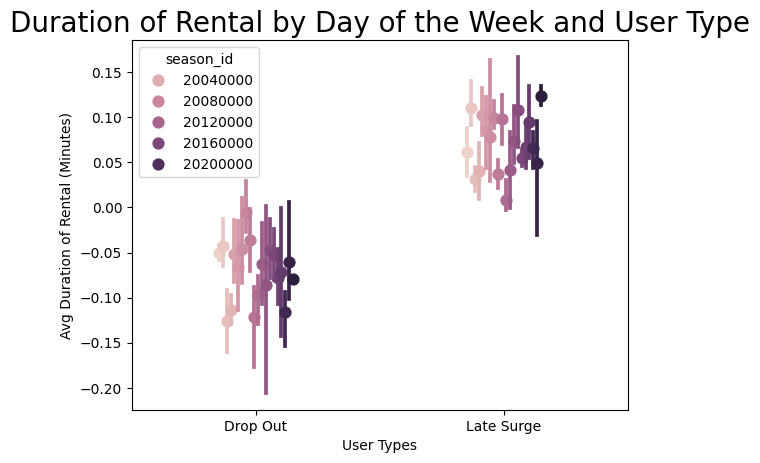

: 

In [ ]:
ax = sb.pointplot(
    data=playoff_changes,
    x="string_situation",
    y="win_pct_diff",
    hue="season_id",
    dodge=0.3,
    linestyles="",
)
ax.set_xlabel("User Types")
ax.set_ylabel("Avg Duration of Rental (Minutes)")
plt.title("Duration of Rental by Day of the Week and User Type", fontsize=20);

c:\Users\kjcs2\GitHub\hockey\hockey_env\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\kjcs2\AppData\Local\Temp\ipykernel_18916\3504536984.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())
C:\Users\kjcs2\AppData\Local\Temp\ipykernel_18916\3504536984.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())
C:\Users\kjcs2\AppData\Local\Temp\ipykernel_18916\3504536984.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())
C:\Users\kjcs2\AppData\Local\Temp\ipykernel_18916\3504536984.py:11: 

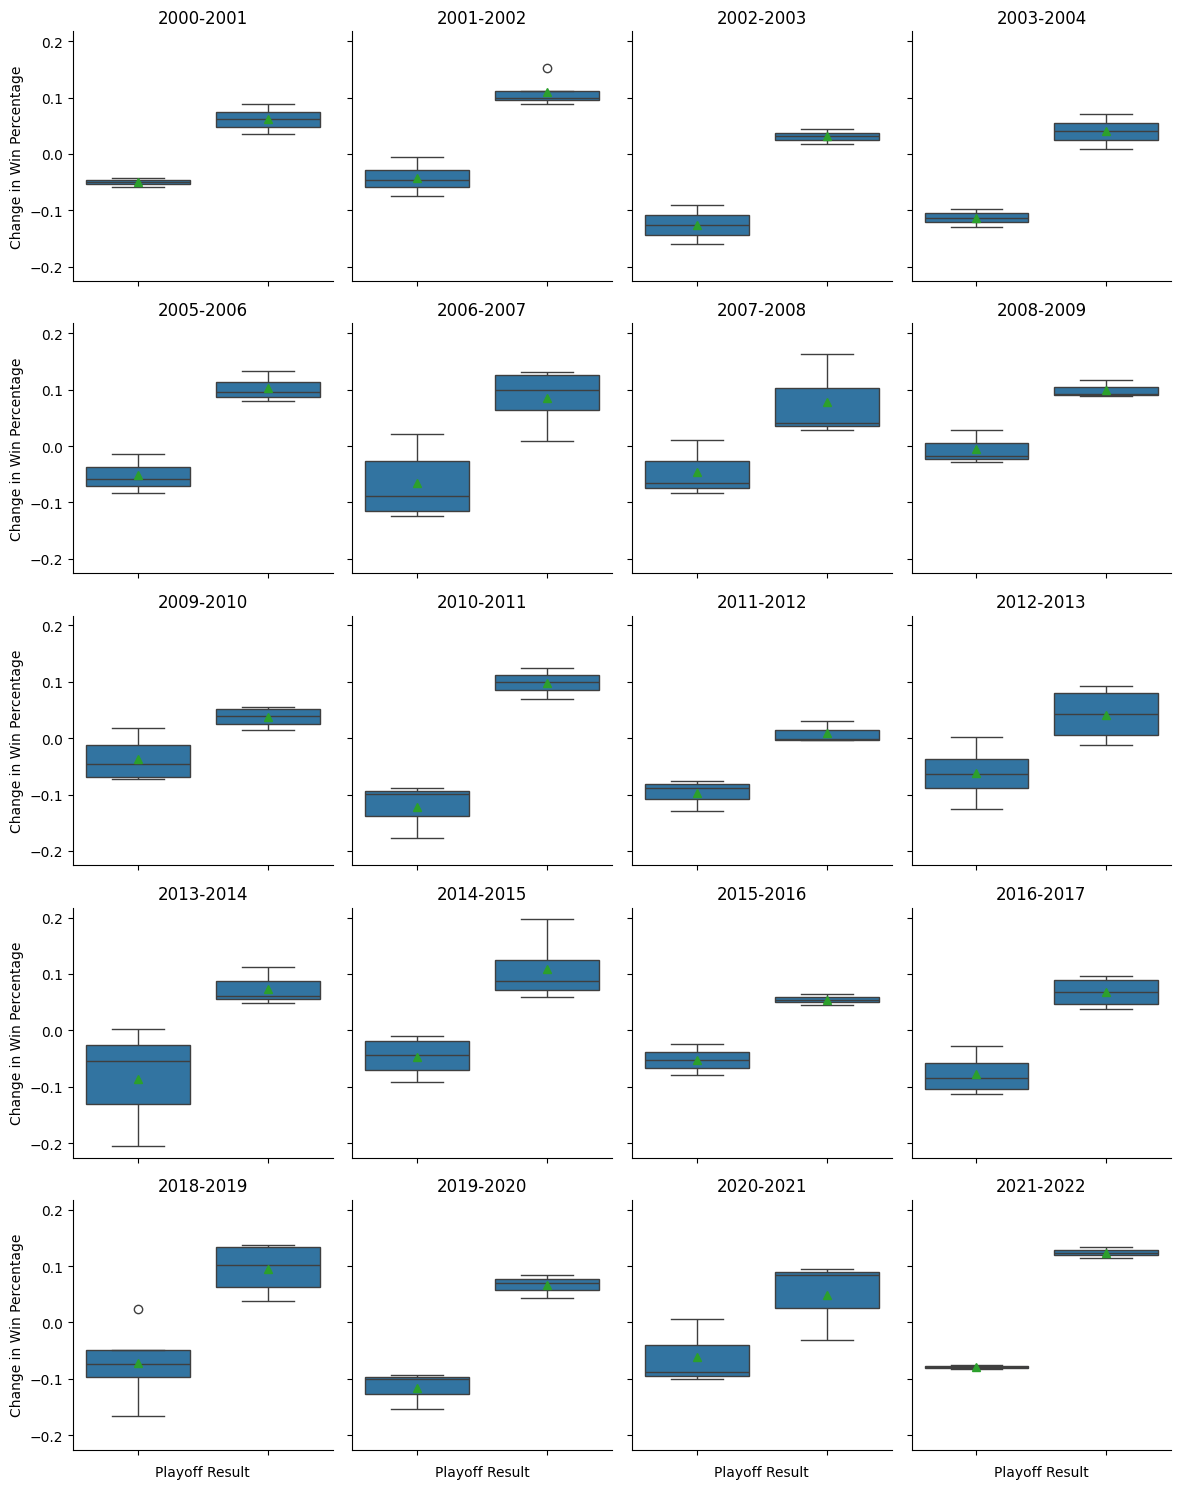

: 

In [ ]:
g = sb.FacetGrid(data=playoff_changes, col="season_id", col_wrap=4)
g.map(sb.boxplot, "string_situation", "win_pct_diff", showmeans=True)
titles = [
    "2000-2001",
    "2001-2002",
    "2002-2003",
    "2003-2004",
    "2005-2006",
    "2006-2007",
    "2007-2008",
    "2008-2009",
    "2009-2010",
    "2010-2011",
    "2011-2012",
    "2012-2013",
    "2013-2014",
    "2014-2015",
    "2015-2016",
    "2016-2017",
    "2018-2019",
    "2021-2022",
    "2022-2023",
    "2023-2024",
]
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
    ax.set_xlabel("Playoff Result")
    ax.set_ylabel("Change in Win Percentage")
    ax.set_xticklabels(ax.get_xticklabels())

    for tick in ax.get_xticklabels():
        tick.set_visible(True)
axes = g.axes.flatten()

plt.tight_layout()

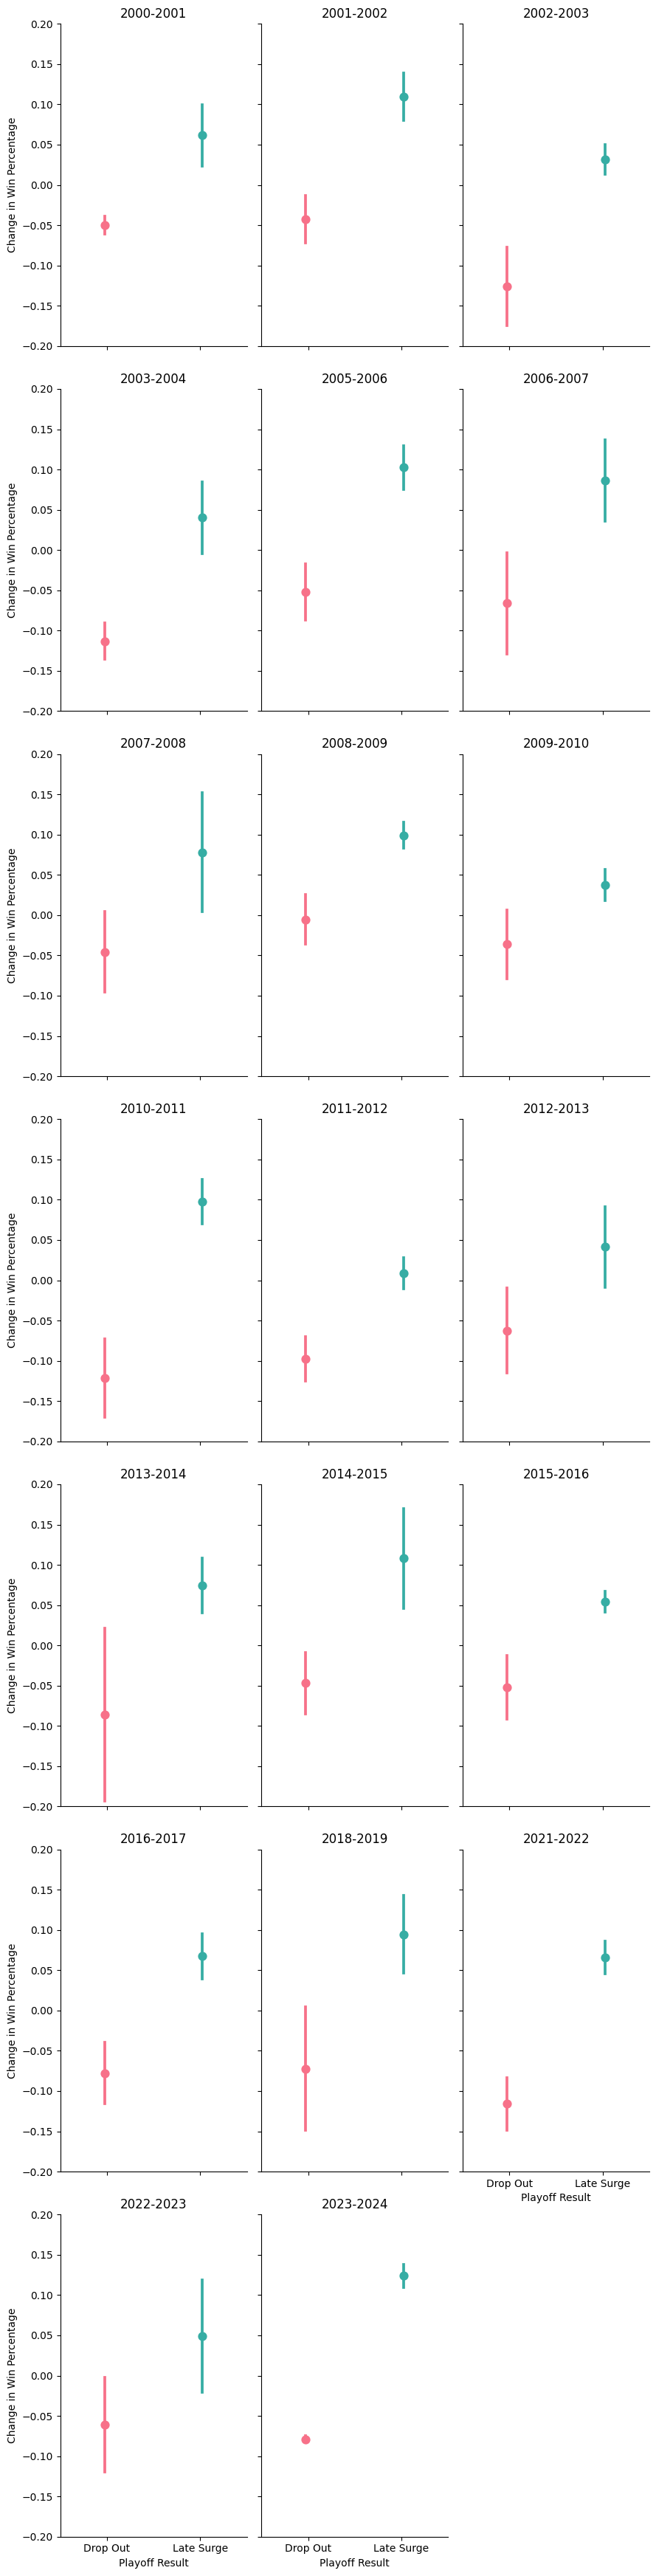

In [ ]:
sns.color_palette("husl", 9)

# Create the FacetGrid
g = sns.FacetGrid(playoff_changes, col="season_id", col_wrap=3, height=5, aspect=0.6)

# Map the data to the FacetGrid
g.map_dataframe(
    sns.pointplot,
    x="string_situation",
    y="win_pct_diff",
    hue="string_situation",
    dodge=True,
    palette="husl",
    errorbar="sd",
)

# Titles and axis labels
titles = [
    "2000-2001",
    "2001-2002",
    "2002-2003",
    "2003-2004",
    "2005-2006",
    "2006-2007",
    "2007-2008",
    "2008-2009",
    "2009-2010",
    "2010-2011",
    "2011-2012",
    "2012-2013",
    "2013-2014",
    "2014-2015",
    "2015-2016",
    "2016-2017",
    "2018-2019",
    "2021-2022",
    "2022-2023",
    "2023-2024",
]
x_labels = ["Late Surge", "Drop Out"]

# Apply titles and labels to each subplot
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
    ax.set_xlabel("Playoff Result")
    ax.set_ylabel("Change in Win Percentage")
    ax.set_ylim(-0.2, 0.2)
    # ax.add_legend(x_labels)

plt.tight_layout()
# do this sep for east v west

In [1]:
playoff_changes.head()

NameError: name 'playoff_changes' is not defined

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import xgboost as xgb
from sklearn.metrics import classification_report

# Ensure SOS is merged into thanksgiving_clean and handle missing values
team_stats_df["SOS"] = team_stats_df["SOS"].fillna(team_stats_df["SOS"].mean())

# Add SOS to the feature set
X = team_stats_df[
    [
        "tx_points",
        "tx_points_pct",
        "tx_goal_diff",
        "christmas",
        "conference",
        "SOS",
        "num_teams",
    ]
]

# Apply one-hot encoding to categorical variables
X = pd.get_dummies(X, drop_first=True)

# Define target
y = team_stats_df["status_b"]  # 1 if made playoffs, 0 otherwise

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Feature importance
importances = xgb_model.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")


              precision    recall  f1-score   support

           0       0.70      0.74      0.72        57
           1       0.76      0.72      0.74        65

    accuracy                           0.73       122
   macro avg       0.73      0.73      0.73       122
weighted avg       0.73      0.73      0.73       122

tx_points: 0.0918
tx_points_pct: 0.4187
tx_goal_diff: 0.1641
christmas: 0.1023
SOS: 0.0911
num_teams: 0.0621
conference_Western: 0.0698


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Select features and target
X = team_stats_df[
    [
        "tx_points",
        "tx_points_pct",
        "tx_goal_diff",
        "christmas",
        "SOS",
        "conference",
        "num_teams",
    ]
]
X = pd.get_dummies(X, drop_first=True)  # Apply one-hot encoding for 'conference'

# Define the target
y = team_stats_df["status_b"]  # 1 for playoffs, 0 otherwise

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    "max_depth": [3, 5, 7],  # Depth of the tree
    "learning_rate": [0.01, 0.1, 0.2],  # Step size shrinkage
    "n_estimators": [100, 200, 300],  # Number of boosting rounds
    "subsample": [0.8, 1.0],  # Subsample ratio of the training instances
    "colsample_bytree": [0.8, 1.0],  # Subsample ratio of columns for each tree
    "gamma": [0, 1],  # Minimum loss reduction
    "reg_alpha": [0, 0.01, 0.1],  # L1 regularization term
    "reg_lambda": [1, 10],  # L2 regularization term
}


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    random_state=42, use_label_encoder=False, eval_metric="logloss"
)

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="accuracy",  # Use accuracy as the evaluation metric
    cv=5,  # 5-fold cross-validation
    verbose=1,  # Display the search progress
    n_jobs=-1,  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and their corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 0.8}
Best Cross-Validation Score: 0.8023564064801179


c:\Users\kjcs2\GitHub\hockey\hockey_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:24:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Retrieve the best model from grid search
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

# Feature Importance
importances = best_model.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")


              precision    recall  f1-score   support

           0       0.75      0.68      0.72        57
           1       0.74      0.80      0.77        65

    accuracy                           0.75       122
   macro avg       0.75      0.74      0.74       122
weighted avg       0.75      0.75      0.74       122

tx_points: 0.2076
tx_points_pct: 0.2810
tx_goal_diff: 0.2223
christmas: 0.2195
SOS: 0.0255
num_teams: 0.0194
conference_Western: 0.0248


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

### Predicting end of this season

In [ ]:
current_season = current_standings
current_season

,conferenceName,leagueSequence,divisionName,gamesPlayed,team_name,tri_code,winPctg,conferenceSequence,date,divisionSequence,points,regulationWins,regulationPlusOtWins,pointPctg,goalDifferential,goalDifferentialPctg,goalFor,season_id,num_teams,projected_points
0,Western,1,Central,36,Winnipeg Jets,WPG,0.694444,1,2024-12-24,1,51,21,25,0.708333,44,1.222222,133,20242025,32,116.0
1,Western,2,Pacific,34,Vegas Golden Knights,VGK,0.676471,2,2024-12-24,1,49,20,22,0.720588,24,0.705882,120,20242025,32,118.0
2,Eastern,3,Metropolitan,37,New Jersey Devils,NJD,0.621622,1,2024-12-24,1,49,22,23,0.662162,33,0.891892,124,20242025,32,109.0
3,Eastern,4,Metropolitan,34,Washington Capitals,WSH,0.676471,2,2024-12-24,2,48,20,23,0.705882,36,1.058824,125,20242025,32,116.0
4,Western,5,Central,35,Minnesota Wild,MIN,0.600000,3,2024-12-24,2,46,17,20,0.657143,8,0.228571,104,20242025,32,108.0
5,Eastern,6,Atlantic,36,Florida Panthers,FLA,0.611111,3,2024-12-24,1,46,18,20,0.638889,14,0.388889,126,20242025,32,105.0
6,Western,7,Pacific,34,Edmonton Oilers,EDM,0.617647,4,2024-12-24,2,44,14,21,0.647059,16,0.470588,111,20242025,32,106.0
7,Eastern,8,Atlantic,35,Toronto Maple Leafs,TOR,0.600000,4,2024-12-24,2,44,18,21,0.628571,10,0.285714,108,20242025,32,103.0
8,Eastern,9,Metropolitan,34,Carolina Hurricanes,CAR,0.617647,5,2024-12-24,3,43,19,21,0.632353,22,0.647059,118,20242025,32,104.0
9,Western,10,Pacific,34,Los Angeles Kings,LAK,0.558824,5,2024-12-24,3,43,19,19,0.632353,16,0.470588,104,20242025,32,104.0


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Initialize the DataFrame
daily_games = pd.DataFrame()

base_url = "https://api-web.nhle.com/v1/schedule/"


start_date = datetime.strptime("2024-10-04", "%Y-%m-%d")
end_date = datetime.strptime("2024-12-24", "%Y-%m-%d")


current_date = start_date

# Set to keep track of unique dates
seen_dates = set()

while current_date <= end_date:
    # Format the date as 'YYYY-MM-DD'
    formatted_date = current_date.strftime("%Y-%m-%d")
    api_url = f"{base_url}{formatted_date}"

    # Make the API request
    response = requests.get(api_url)

    if response.status_code == 200:
        # The response content can be accessed using response.text
        response_text = response.text
    # pprint(response_text)
    else:
        print(f"Request failed with status code {response.status_code}")

    json_data = json.loads(response_text)

    game_week = json_data["gameWeek"]
    game_week_df = pd.DataFrame(game_week)

    game_week_df = game_week_df[game_week_df["numberOfGames"] != 0]

    # Filter out rows with duplicate dates
    if formatted_date not in seen_dates:
        seen_dates.add(formatted_date)
        daily_games = pd.concat([daily_games, game_week_df], ignore_index=True)
    else:
        print(f"Failed to retrieve data for {formatted_date}")

    # Move to the next week
    current_date += timedelta(weeks=1)
    # Filter out rows where 'date' is after the end date
    daily_games["date"] = pd.to_datetime(daily_games["date"])
    daily_games = daily_games[daily_games["date"] <= end_date]

    # Reset index after filtering
    daily_games.reset_index(drop=True, inplace=True)

    game_week_details = pd.json_normalize(daily_games["games"])


# in order to extract the data properly, it needs to be stored in a dictionary. This extracts each of the games from the cells

dfs = {}

# Loop through the iterations (30 times)
for i in range(0, len(game_week_details.columns)):
    api_response = game_week

    if api_response is not None:
        # Extract relevant data from the API response and normalize it
        game_info = pd.json_normalize(game_week_details[i])

        # Create a DataFrame for this iteration
        df_name = f"game_test{i}"  # Generate a unique variable name
        dfs[df_name] = pd.DataFrame(game_info)
    else:
        # Handle the case where the API request failed
        print(f"API request failed for index {i}")

# Then I combine all of the dfs in the list by concatenation to create a single df. now all of the game data is spread out across each row.
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df.dropna(how="all", inplace=True)


combined_df = combined_df[
    [
        "id",
        "season",
        "startTimeUTC",
        "gameType",
        "awayTeam.id",
        "awayTeam.abbrev",
        "awayTeam.logo",
        "homeTeam.id",
        "homeTeam.abbrev",
        "homeTeam.logo",
        "homeTeam.placeName.default",
        "awayTeam.placeName.default",
        "awayTeam.score",
        "homeTeam.score",
        "winningGoalScorer.playerId",
        "winningGoalie.playerId",
        "gameState",
    ]
]


combined_df = combined_df.convert_dtypes()
combined_df["id"] = combined_df["id"].astype(str)

combined_df["link"] = (
    "https://api-web.nhle.com/v1/gamecenter/" + combined_df["id"] + "/play-by-play"
)

# Assuming '<NA>' is a string, replace it with np.nan
combined_df["id"] = combined_df["id"].replace("<NA>", np.nan)

# Drop rows with NaN values in the 'link' column
combined_df = combined_df.dropna(subset=["id"])
combined_df = combined_df.query('gameState == "OFF"')
combined_df["startTimeUTC"] = pd.to_datetime(combined_df["startTimeUTC"])
combined_df = combined_df.rename(columns={"id": "game_id"})
combined_df = combined_df.sort_values("game_id").reset_index()


# Specify the UTC time zone
utc_timezone = pytz.utc

# Specify the target time zone (Eastern Time)
eastern_timezone = pytz.timezone("America/New_York")

# Convert 'startTimeUTC' to Eastern Time
combined_df["game_date_time"] = combined_df["startTimeUTC"].dt.tz_convert(
    eastern_timezone
)
combined_df["game_date_time"] = pd.to_datetime(combined_df["game_date_time"])
combined_df["start_time"] = (
    combined_df["game_date_time"].dt.strftime("%I:%M %p").str.lstrip("0").str.lower()
)
combined_df["game_date"] = combined_df["game_date_time"].dt.strftime("%Y-%m-%d")
combined_df.drop("startTimeUTC", axis=1, inplace=True)
# combined_df = combined_df[combined_df['game_date'] == formatted_date]
combined_df.sort_values(by="game_id")
# print("combined_df done")
combined_df.head()


,index,game_id,season,gameType,awayTeam.id,awayTeam.abbrev,awayTeam.logo,homeTeam.id,homeTeam.abbrev,homeTeam.logo,homeTeam.placeName.default,awayTeam.placeName.default,awayTeam.score,homeTeam.score,winningGoalScorer.playerId,winningGoalie.playerId,gameState,link,game_date_time,start_time,game_date
0,0,2024020001,20242025,2,1,NJD,https://assets.nhle.com/logos/nhl/svg/NJD_ligh...,7,BUF,https://assets.nhle.com/logos/nhl/svg/BUF_ligh...,Buffalo,New Jersey,4,1,8480192,8474593,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-04 13:00:00-04:00,1:00 pm,2024-10-04
1,1,2024020002,20242025,2,7,BUF,https://assets.nhle.com/logos/nhl/svg/BUF_ligh...,1,NJD,https://assets.nhle.com/logos/nhl/svg/NJD_ligh...,New Jersey,Buffalo,1,3,8481032,8474596,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-05 10:00:00-04:00,10:00 am,2024-10-05
2,3,2024020003,20242025,2,19,STL,https://assets.nhle.com/logos/nhl/svg/STL_ligh...,55,SEA,https://assets.nhle.com/logos/nhl/svg/SEA_ligh...,Seattle,St. Louis,3,2,8479385,8476412,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-08 16:30:00-04:00,4:30 pm,2024-10-08
3,82,2024020004,20242025,2,6,BOS,https://assets.nhle.com/logos/nhl/svg/BOS_ligh...,13,FLA,https://assets.nhle.com/logos/nhl/svg/FLA_ligh...,Florida,Boston,4,6,8479981,8475683,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-08 19:00:00-04:00,7:00 pm,2024-10-08
4,161,2024020005,20242025,2,16,CHI,https://assets.nhle.com/logos/nhl/svg/CHI_ligh...,59,UTA,https://assets.nhle.com/logos/nhl/svg/UTA_ligh...,Utah,Chicago,2,5,8480849,8478971,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-08 22:00:00-04:00,10:00 pm,2024-10-08


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [45]:
final_df2 = combined_df

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Step 1: Calculate each team's win percentage based on game outcomes
team_stats = []


def calculate_team_win_percentage(team_abbrev, df):
    # Count wins as the team being either home or away
    wins = len(
        df[
            (df["awayTeam.abbrev"] == team_abbrev)
            & (df["awayTeam.score"] > df["homeTeam.score"])
        ]
    ) + len(
        df[
            (df["homeTeam.abbrev"] == team_abbrev)
            & (df["homeTeam.score"] > df["awayTeam.score"])
        ]
    )
    games = len(
        df[
            (df["awayTeam.abbrev"] == team_abbrev)
            | (df["homeTeam.abbrev"] == team_abbrev)
        ]
    )
    win_percentage = wins / games if games > 0 else 0
    return win_percentage


# Calculate win percentages for all teams
team_abbrevs = pd.concat(
    [final_df2["awayTeam.abbrev"], final_df2["homeTeam.abbrev"]]
).unique()
for team_abbrev in team_abbrevs:
    win_percentage = calculate_team_win_percentage(team_abbrev, final_df2)
    team_stats.append({"team_abbrev": team_abbrev, "win_percentage": win_percentage})

# Convert team_stats into a DataFrame
team_stats_df = pd.DataFrame(team_stats)

# Step 2: Map the win percentages to final_df2
final_df2["awayTeam_win_percentage"] = final_df2["awayTeam.abbrev"].map(
    team_stats_df.set_index("team_abbrev")["win_percentage"]
)
final_df2["homeTeam_win_percentage"] = final_df2["homeTeam.abbrev"].map(
    team_stats_df.set_index("team_abbrev")["win_percentage"]
)
final_df2.head()

,index,game_id,season,gameType,awayTeam.id,awayTeam.abbrev,awayTeam.logo,homeTeam.id,homeTeam.abbrev,homeTeam.logo,homeTeam.placeName.default,awayTeam.placeName.default,awayTeam.score,homeTeam.score,winningGoalScorer.playerId,winningGoalie.playerId,gameState,link,game_date_time,start_time,game_date,awayTeam_win_percentage,homeTeam_win_percentage
0,0,2024020001,20242025,2,1,NJD,https://assets.nhle.com/logos/nhl/svg/NJD_ligh...,7,BUF,https://assets.nhle.com/logos/nhl/svg/BUF_ligh...,Buffalo,New Jersey,4,1,8480192,8474593,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-04 13:00:00-04:00,1:00 pm,2024-10-04,0.621622,0.342857
1,1,2024020002,20242025,2,7,BUF,https://assets.nhle.com/logos/nhl/svg/BUF_ligh...,1,NJD,https://assets.nhle.com/logos/nhl/svg/NJD_ligh...,New Jersey,Buffalo,1,3,8481032,8474596,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-05 10:00:00-04:00,10:00 am,2024-10-05,0.342857,0.621622
2,3,2024020003,20242025,2,19,STL,https://assets.nhle.com/logos/nhl/svg/STL_ligh...,55,SEA,https://assets.nhle.com/logos/nhl/svg/SEA_ligh...,Seattle,St. Louis,3,2,8479385,8476412,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-08 16:30:00-04:00,4:30 pm,2024-10-08,0.444444,0.416667
3,82,2024020004,20242025,2,6,BOS,https://assets.nhle.com/logos/nhl/svg/BOS_ligh...,13,FLA,https://assets.nhle.com/logos/nhl/svg/FLA_ligh...,Florida,Boston,4,6,8479981,8475683,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-08 19:00:00-04:00,7:00 pm,2024-10-08,0.527778,0.611111
4,161,2024020005,20242025,2,16,CHI,https://assets.nhle.com/logos/nhl/svg/CHI_ligh...,59,UTA,https://assets.nhle.com/logos/nhl/svg/UTA_ligh...,Utah,Chicago,2,5,8480849,8478971,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-08 22:00:00-04:00,10:00 pm,2024-10-08,0.342857,0.470588


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Step 3: Calculate SOS for each team
# Calculate SOS for away teams, including season
away_team_sos = (
    final_df2.groupby(["season", "awayTeam.abbrev"])["homeTeam_win_percentage"]
    .mean()
    .reset_index()
)
away_team_sos.rename(columns={"homeTeam_win_percentage": "SOS"}, inplace=True)

# Calculate SOS for home teams, including season
home_team_sos = (
    final_df2.groupby(["season", "homeTeam.abbrev"])["awayTeam_win_percentage"]
    .mean()
    .reset_index()
)
home_team_sos.rename(columns={"awayTeam_win_percentage": "SOS"}, inplace=True)

# Merge the SOS data for both away and home teams
team_sos = pd.concat([away_team_sos, home_team_sos], axis=0)

# Group by season and team abbreviation to compute the average SOS across all occurrences
team_sos = team_sos.groupby(["season", "awayTeam.abbrev"])["SOS"].mean().reset_index()

# Rename the column for clarity
team_sos.rename(
    columns={"awayTeam.abbrev": "tri_code", "season": "season_id"}, inplace=True
)

# Output the final SOS data
print(team_sos[["season_id", "tri_code", "SOS"]])


    season_id tri_code       SOS
0    20242025      ANA  0.494938
1    20242025      BOS  0.498355
2    20242025      BUF  0.456210
3    20242025      CAR  0.501074
4    20242025      CBJ  0.502548
5    20242025      CGY  0.476022
6    20242025      CHI  0.518912
7    20242025      COL  0.493994
8    20242025      DAL  0.529474
9    20242025      DET  0.421771
10   20242025      EDM  0.489939
11   20242025      FLA  0.490400
12   20242025      LAK  0.465065
13   20242025      MIN  0.480233
14   20242025      MTL  0.499222
15   20242025      NJD  0.511661
16   20242025      NSH  0.538057
17   20242025      NYI  0.503354
18   20242025      NYR  0.486928
19   20242025      OTT  0.504332
20   20242025      PHI  0.510257
21   20242025      PIT  0.506929
22   20242025      SEA  0.505924
23   20242025      SJS  0.535079
24   20242025      STL  0.513717
25   20242025      TBL  0.529103
26   20242025      TOR  0.531915
27   20242025      UTA  0.497819
28   20242025      VAN  0.480017
29   20242

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [48]:
# current_season['num_teams'] = 32
# current_season.head()

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [49]:
current_standings.head()

,conferenceName,leagueSequence,divisionName,gamesPlayed,team_name,tri_code,winPctg,conferenceSequence,date,divisionSequence,points,regulationWins,regulationPlusOtWins,pointPctg,goalDifferential,goalDifferentialPctg,goalFor,season_id,num_teams,projected_points
0,Western,1,Central,36,Winnipeg Jets,WPG,0.694444,1,2024-12-24,1,51,21,25,0.708333,44,1.222222,133,20242025,32,116.0
1,Western,2,Pacific,34,Vegas Golden Knights,VGK,0.676471,2,2024-12-24,1,49,20,22,0.720588,24,0.705882,120,20242025,32,118.0
2,Eastern,3,Metropolitan,37,New Jersey Devils,NJD,0.621622,1,2024-12-24,1,49,22,23,0.662162,33,0.891892,124,20242025,32,109.0
3,Eastern,4,Metropolitan,34,Washington Capitals,WSH,0.676471,2,2024-12-24,2,48,20,23,0.705882,36,1.058824,125,20242025,32,116.0
4,Western,5,Central,35,Minnesota Wild,MIN,0.600000,3,2024-12-24,2,46,17,20,0.657143,8,0.228571,104,20242025,32,108.0


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
current_prediction = current_standings.merge(
    team_sos, on=["tri_code", "season_id"], how="left"
)


# Step 5: Clean up final DataFramev and rename columns for clarity
current_prediction.rename(columns={"homeTeam_win_percentage": "SOS"}, inplace=True)


current_prediction.head()

,conferenceName,leagueSequence,divisionName,gamesPlayed,team_name,tri_code,winPctg,conferenceSequence,date,divisionSequence,points,regulationWins,regulationPlusOtWins,pointPctg,goalDifferential,goalDifferentialPctg,goalFor,season_id,num_teams,projected_points,SOS
0,Western,1,Central,36,Winnipeg Jets,WPG,0.694444,1,2024-12-24,1,51,21,25,0.708333,44,1.222222,133,20242025,32,116.0,0.479209
1,Western,2,Pacific,34,Vegas Golden Knights,VGK,0.676471,2,2024-12-24,1,49,20,22,0.720588,24,0.705882,120,20242025,32,118.0,0.541065
2,Eastern,3,Metropolitan,37,New Jersey Devils,NJD,0.621622,1,2024-12-24,1,49,22,23,0.662162,33,0.891892,124,20242025,32,109.0,0.511661
3,Eastern,4,Metropolitan,34,Washington Capitals,WSH,0.676471,2,2024-12-24,2,48,20,23,0.705882,36,1.058824,125,20242025,32,116.0,0.538316
4,Western,5,Central,35,Minnesota Wild,MIN,0.600000,3,2024-12-24,2,46,17,20,0.657143,8,0.228571,104,20242025,32,108.0,0.480233


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
prediction_df = current_prediction[
    [
        "tri_code",
        "team_name",
        "gamesPlayed",
        "points",
        "pointPctg",
        "goalDifferentialPctg",
        "conferenceSequence",
        "SOS",
        "conferenceName",
        "num_teams",
        "winPctg",
    ]
]
prediction_df.rename(
    columns={
        "teamName.default": "team_name",
        "points": "tx_points",
        "pointPctg": "tx_points_pct",
        "goalDifferentialPctg": "tx_goal_diff",
        "conferenceSequence": "christmas",
        "conferenceName": "conference",
    },
    inplace=True,
)
projected_points_df = prediction_df
prediction_df.head()

,tri_code,team_name,gamesPlayed,tx_points,tx_points_pct,tx_goal_diff,christmas,SOS,conference,num_teams,winPctg
0,WPG,Winnipeg Jets,36,51,0.708333,1.222222,1,0.479209,Western,32,0.694444
1,VGK,Vegas Golden Knights,34,49,0.720588,0.705882,2,0.541065,Western,32,0.676471
2,NJD,New Jersey Devils,37,49,0.662162,0.891892,1,0.511661,Eastern,32,0.621622
3,WSH,Washington Capitals,34,48,0.705882,1.058824,2,0.538316,Eastern,32,0.676471
4,MIN,Minnesota Wild,35,46,0.657143,0.228571,3,0.480233,Western,32,0.600000


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Step 1: Create dummy variables for 'conference'
prediction_df = pd.get_dummies(prediction_df, columns=["conference"], drop_first=True)

# Step 2: Ensure 'conference_Western' exists, even if it's missing
if "conference_Western" not in prediction_df.columns:
    prediction_df["conference_Western"] = 0  # Add with all zeros if missing

# Step 3: Define the feature set for prediction
model_features = [
    "tx_points",
    "tx_points_pct",
    "tx_goal_diff",
    "christmas",
    "SOS",
    "num_teams",
    "conference_Western",
]
prediction_features = prediction_df.reindex(columns=model_features, fill_value=0)

# Step 4: Make predictions
prediction_df["predicted_status"] = best_model.predict(prediction_features)

# Step 5: Keep a copy of identifying information (team name, etc.)
identifying_columns = [
    "team_name",
    "gamesPlayed",
    "conference_Western",
    "tx_points",
]  # Adjust to your identifying column names
identifying_info = prediction_df[identifying_columns].copy()  # Copy identifying columns

# Step 6: Add predictions to identifying information
results_df = identifying_info.copy()  # Copy identifying info into results_df
results_df["predicted_status"] = prediction_df[
    "predicted_status"
]  # Add predictions to results

# Step 7: Map predictions to human-readable labels
results_df["playoff_prediction"] = results_df["predicted_status"].map(
    {1: "Make Playoffs", 0: "Miss Playoffs"}
)
results_df.head()

,team_name,gamesPlayed,conference_Western,tx_points,predicted_status,playoff_prediction
0,Winnipeg Jets,36,True,51,1,Make Playoffs
1,Vegas Golden Knights,34,True,49,1,Make Playoffs
2,New Jersey Devils,37,False,49,1,Make Playoffs
3,Washington Capitals,34,False,48,1,Make Playoffs
4,Minnesota Wild,35,True,46,1,Make Playoffs


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
results_df["projected_points"] = round(
    (results_df["tx_points"] / results_df["gamesPlayed"]) * 82
)
results_df

,team_name,gamesPlayed,conference_Western,tx_points,predicted_status,playoff_prediction,projected_points
0,Winnipeg Jets,36,True,51,1,Make Playoffs,116.0
1,Vegas Golden Knights,34,True,49,1,Make Playoffs,118.0
2,New Jersey Devils,37,False,49,1,Make Playoffs,109.0
3,Washington Capitals,34,False,48,1,Make Playoffs,116.0
4,Minnesota Wild,35,True,46,1,Make Playoffs,108.0
5,Florida Panthers,36,False,46,1,Make Playoffs,105.0
6,Edmonton Oilers,34,True,44,1,Make Playoffs,106.0
7,Toronto Maple Leafs,35,False,44,1,Make Playoffs,103.0
8,Carolina Hurricanes,34,False,43,1,Make Playoffs,104.0
9,Los Angeles Kings,34,True,43,1,Make Playoffs,104.0


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
results_df_sorted = results_df.sort_values(
    by=["conference_Western", "predicted_status", "projected_points"],
    ascending=[True, False, False],
)

# # Step 6: Select top 8 teams per conference
# top_8_teams_per_conference = results_df_sorted.groupby('conference_Western').head(8)

# # Step 7: Display the final results
# print(top_8_teams_per_conference)
results_df_sorted

,team_name,gamesPlayed,conference_Western,tx_points,predicted_status,playoff_prediction,projected_points
3,Washington Capitals,34,False,48,1,Make Playoffs,116.0
2,New Jersey Devils,37,False,49,1,Make Playoffs,109.0
5,Florida Panthers,36,False,46,1,Make Playoffs,105.0
8,Carolina Hurricanes,34,False,43,1,Make Playoffs,104.0
7,Toronto Maple Leafs,35,False,44,1,Make Playoffs,103.0
13,Tampa Bay Lightning,32,False,40,1,Make Playoffs,102.0
11,Boston Bruins,36,False,42,1,Make Playoffs,96.0
16,Ottawa Senators,34,False,38,1,Make Playoffs,92.0
18,Pittsburgh Penguins,36,False,37,0,Miss Playoffs,84.0
20,Columbus Blue Jackets,35,False,34,0,Miss Playoffs,80.0


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

### New Projected Points formula

In [55]:
projected_points_df.head()

,tri_code,team_name,gamesPlayed,tx_points,tx_points_pct,tx_goal_diff,christmas,SOS,conference,num_teams,winPctg
0,WPG,Winnipeg Jets,36,51,0.708333,1.222222,1,0.479209,Western,32,0.694444
1,VGK,Vegas Golden Knights,34,49,0.720588,0.705882,2,0.541065,Western,32,0.676471
2,NJD,New Jersey Devils,37,49,0.662162,0.891892,1,0.511661,Eastern,32,0.621622
3,WSH,Washington Capitals,34,48,0.705882,1.058824,2,0.538316,Eastern,32,0.676471
4,MIN,Minnesota Wild,35,46,0.657143,0.228571,3,0.480233,Western,32,0.600000


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# traditional projected final points calculation
games_remaining = 82 - projected_points_df["gamesPlayed"]
points_per_game = projected_points_df["tx_points"] / projected_points_df["gamesPlayed"]
projected_points_df["projected_points"] = round(
    projected_points_df["tx_points"] + (games_remaining * points_per_game)
)
projected_points_df.head()

,tri_code,team_name,gamesPlayed,tx_points,tx_points_pct,tx_goal_diff,christmas,SOS,conference,num_teams,winPctg,projected_points
0,WPG,Winnipeg Jets,36,51,0.708333,1.222222,1,0.479209,Western,32,0.694444,116.0
1,VGK,Vegas Golden Knights,34,49,0.720588,0.705882,2,0.541065,Western,32,0.676471,118.0
2,NJD,New Jersey Devils,37,49,0.662162,0.891892,1,0.511661,Eastern,32,0.621622,109.0
3,WSH,Washington Capitals,34,48,0.705882,1.058824,2,0.538316,Eastern,32,0.676471,116.0
4,MIN,Minnesota Wild,35,46,0.657143,0.228571,3,0.480233,Western,32,0.600000,108.0


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# clean up names
projected_points_df = projected_points_df.rename(
    columns={
        "tx_points": "points",
        "tx_points_pct": "points_percentage",
        "tx_goal_diff": "goal_diff",
        "christmas": "conference_standings",
    }
)
projected_points_df.head()

,tri_code,team_name,gamesPlayed,points,points_percentage,goal_diff,conference_standings,SOS,conference,num_teams,winPctg,projected_points
0,WPG,Winnipeg Jets,36,51,0.708333,1.222222,1,0.479209,Western,32,0.694444,116.0
1,VGK,Vegas Golden Knights,34,49,0.720588,0.705882,2,0.541065,Western,32,0.676471,118.0
2,NJD,New Jersey Devils,37,49,0.662162,0.891892,1,0.511661,Eastern,32,0.621622,109.0
3,WSH,Washington Capitals,34,48,0.705882,1.058824,2,0.538316,Eastern,32,0.676471,116.0
4,MIN,Minnesota Wild,35,46,0.657143,0.228571,3,0.480233,Western,32,0.600000,108.0


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# remaining Schedule

# get games this season

# Initialize the DataFrame
daily_games = pd.DataFrame()

base_url = "https://api-web.nhle.com/v1/schedule/"
# start_date = datetime.strptime("2023-10-09", "%Y-%m-%d")
# end_date = datetime.strptime("2024-04-17", "%Y-%m-%d")

start_date = datetime.strptime("2024-12-26", "%Y-%m-%d")
end_date = datetime.strptime("2025-04-17", "%Y-%m-%d")


current_date = start_date

# Set to keep track of unique dates
seen_dates = set()

while current_date <= end_date:
    # Format the date as 'YYYY-MM-DD'
    formatted_date = current_date.strftime("%Y-%m-%d")
    api_url = f"{base_url}{formatted_date}"

    # Make the API request
    response = requests.get(api_url)

    if response.status_code == 200:
        # The response content can be accessed using response.text
        response_text = response.text
    # pprint(response_text)
    else:
        print(f"Request failed with status code {response.status_code}")

    json_data = json.loads(response_text)

    game_week = json_data["gameWeek"]
    game_week_df = pd.DataFrame(game_week)

    game_week_df = game_week_df[game_week_df["numberOfGames"] != 0]

    # Filter out rows with duplicate dates
    if formatted_date not in seen_dates:
        seen_dates.add(formatted_date)
        daily_games = pd.concat([daily_games, game_week_df], ignore_index=True)
    else:
        print(f"Failed to retrieve data for {formatted_date}")

    # Move to the next week
    current_date += timedelta(weeks=1)
    # Filter out rows where 'date' is after the end date
    daily_games["date"] = pd.to_datetime(daily_games["date"])
    daily_games = daily_games[daily_games["date"] <= end_date]

    # Reset index after filtering
    daily_games.reset_index(drop=True, inplace=True)

    game_week_details = pd.json_normalize(daily_games["games"])
game_week_details.tail()


# in order to extract the data properly, it needs to be stored in a dictionary. This extracts each of the games from the cells

dfs = {}

# Loop through the iterations (30 times)
for i in range(0, len(game_week_details.columns)):
    api_response = game_week

    if api_response is not None:
        # Extract relevant data from the API response and normalize it
        game_info = pd.json_normalize(game_week_details[i])

        # Create a DataFrame for this iteration
        df_name = f"game_test{i}"  # Generate a unique variable name
        dfs[df_name] = pd.DataFrame(game_info)
    else:
        # Handle the case where the API request failed
        print(f"API request failed for index {i}")

# Then I combine all of the dfs in the list by concatenation to create a single df. now all of the game data is spread out across each row.
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df.dropna(how="all", inplace=True)


combined_df = combined_df[
    [
        "id",
        "season",
        "startTimeUTC",
        "awayTeam.id",
        "awayTeam.abbrev",
        "homeTeam.id",
        "homeTeam.abbrev",
        "awayTeam.score",
        "homeTeam.score",
    ]
]


combined_df = combined_df.convert_dtypes()
combined_df["id"] = combined_df["id"].astype(str)


# Assuming '<NA>' is a string, replace it with np.nan
combined_df["id"] = combined_df["id"].replace("<NA>", np.nan)

# Drop rows with NaN values in the 'link' column
combined_df = combined_df.dropna(subset=["id"])
combined_df["startTimeUTC"] = pd.to_datetime(combined_df["startTimeUTC"])
combined_df = combined_df.rename(columns={"id": "game_id"})
combined_df = combined_df.sort_values("game_id").reset_index()
# Filter rows where 'game_id' starts with "202402"
combined_df = combined_df[combined_df["game_id"].astype(str).str.startswith("202402")]


# Specify the UTC time zone
utc_timezone = pytz.utc

# Specify the target time zone (Eastern Time)
eastern_timezone = pytz.timezone("America/New_York")

# Convert 'startTimeUTC' to Eastern Time
combined_df["game_date_time"] = combined_df["startTimeUTC"].dt.tz_convert(
    eastern_timezone
)
combined_df["game_date_time"] = pd.to_datetime(combined_df["game_date_time"])
combined_df["start_time"] = (
    combined_df["game_date_time"].dt.strftime("%I:%M %p").str.lstrip("0").str.lower()
)
combined_df["game_date"] = combined_df["game_date_time"].dt.strftime("%Y-%m-%d")
combined_df.drop("startTimeUTC", axis=1, inplace=True)
# combined_df = combined_df[combined_df['game_date'] == formatted_date]
combined_df.sort_values(by="game_id")
# print("combined_df done")
combined_df = combined_df.rename(
    columns={"awayTeam.abbrev": "away_team", "homeTeam.abbrev": "home_team"}
)
combined_df.tail()


,index,game_id,season,awayTeam.id,away_team,homeTeam.id,home_team,awayTeam.score,homeTeam.score,game_date_time,start_time,game_date
751,209,2024021308,20242025,17,DET,10,TOR,<NA>,<NA>,2025-04-17 19:00:00-04:00,7:00 pm,2025-04-17
752,314,2024021309,20242025,12,CAR,9,OTT,<NA>,<NA>,2025-04-17 19:00:00-04:00,7:00 pm,2025-04-17
753,419,2024021310,20242025,14,TBL,3,NYR,<NA>,<NA>,2025-04-17 19:00:00-04:00,7:00 pm,2025-04-17
754,524,2024021311,20242025,15,WSH,5,PIT,<NA>,<NA>,2025-04-17 19:00:00-04:00,7:00 pm,2025-04-17
755,629,2024021312,20242025,2,NYI,29,CBJ,<NA>,<NA>,2025-04-17 19:00:00-04:00,7:00 pm,2025-04-17


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
game_schedule = combined_df[
    ["game_id", "awayTeam.id", "away_team", "homeTeam.id", "home_team", "game_date"]
]
game_schedule.head()

,game_id,awayTeam.id,away_team,homeTeam.id,home_team,game_date
0,2024020029,12,CAR,14,TBL,2025-01-07
1,2024020558,16,CHI,7,BUF,2024-12-27
2,2024020559,10,TOR,17,DET,2024-12-27
3,2024020560,12,CAR,1,NJD,2024-12-27
4,2024020561,6,BOS,29,CBJ,2024-12-27


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [60]:
game_schedule.columns

Index(['game_id', 'awayTeam.id', 'away_team', 'homeTeam.id', 'home_team',
       'game_date'],
      dtype='object')

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
completed_games = completed_games[
    [
        "game_id",
        "awayTeam.id",
        "awayTeam.abbrev",
        "awayTeam.score",
        "homeTeam.score",
        "homeTeam.id",
        "homeTeam.abbrev",
        "game_date",
    ]
]
completed_games = completed_games.rename(
    columns={"awayTeam.abbrev": "away_team", "homeTeam.abbrev": "home_team"}
)
completed_games.head()

,game_id,awayTeam.id,away_team,awayTeam.score,homeTeam.score,homeTeam.id,home_team,game_date
0,2024010044,18,NSH,<NA>,<NA>,14,TBL,2024-10-07
1,2024010090,29,CBJ,3,7,5,PIT,2024-10-04
2,2024010091,3,NYR,2,5,2,NYI,2024-10-04
3,2024010092,9,OTT,4,3,17,DET,2024-10-04
4,2024010093,14,TBL,1,2,12,CAR,2024-10-04


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
projected_points_df["ppg"] = (
    projected_points_df["points"] / projected_points_df["gamesPlayed"]
)
projected_points_df.head()

,tri_code,team_name,gamesPlayed,points,points_percentage,goal_diff,conference_standings,SOS,conference,num_teams,winPctg,projected_points,ppg
0,WPG,Winnipeg Jets,36,51,0.708333,1.222222,1,0.479209,Western,32,0.694444,116.0,1.416667
1,VGK,Vegas Golden Knights,34,49,0.720588,0.705882,2,0.541065,Western,32,0.676471,118.0,1.441176
2,NJD,New Jersey Devils,37,49,0.662162,0.891892,1,0.511661,Eastern,32,0.621622,109.0,1.324324
3,WSH,Washington Capitals,34,48,0.705882,1.058824,2,0.538316,Eastern,32,0.676471,116.0,1.411765
4,MIN,Minnesota Wild,35,46,0.657143,0.228571,3,0.480233,Western,32,0.600000,108.0,1.314286


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Create a function to collect all opponents for a given team
def get_remaining_opponents(team, schedule):
    home_opponents = schedule[schedule["home_team"] == team]["away_team"].tolist()
    away_opponents = schedule[schedule["away_team"] == team]["home_team"].tolist()
    return home_opponents + away_opponents


# Add remaining opponents to the projected_points_df
projected_points_df["remaining_opponents"] = projected_points_df["tri_code"].apply(
    lambda team: get_remaining_opponents(team, game_schedule)
)

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
def calculate_remaining_points(team, projected_points_df, game_schedule):
    # Get the team's current projected points and win percentage
    base_points = projected_points_df.loc[
        projected_points_df["tri_code"] == team, "projected_points"
    ].values[0]
    win_pctg = projected_points_df.loc[
        projected_points_df["tri_code"] == team, "winPctg"
    ].values[0]

    # Get the team's remaining opponents
    remaining_opponents = projected_points_df.loc[
        projected_points_df["tri_code"] == team, "remaining_opponents"
    ].values[0]

    # Calculate the expected points from remaining games based on win percentage
    num_remaining_games = len(remaining_opponents)

    # Expected points = (winPctg * 2 points per game) for each remaining game
    expected_remaining_points = (
        num_remaining_games * win_pctg * 2
    )  # 2 points for a win, based on winPctg

    # Calculate the total points after remaining games
    final_points = base_points + expected_remaining_points

    # Now factor in remaining opponent strength, but conservatively
    opponent_strength_factor = (
        1  # We will adjust this factor based on the strength of remaining opponents
    )
    for opp in remaining_opponents:
        opp_sos = projected_points_df.loc[
            projected_points_df["team_name"] == opp, "SOS"
        ].values[0]
        opponent_strength_factor *= (
            1 - opp_sos
        )  # Stronger opponents should reduce the potential points

    # Apply the opponent strength adjustment
    adjusted_final_points = final_points * opponent_strength_factor

    # Ensure the final projection stays within a reasonable range (avoid going too high)
    # You can set your own upper limit here if needed
    adjusted_final_points = min(adjusted_final_points, 118)

    return adjusted_final_points


# Apply the calculation to all teams in the DataFrame
projected_points_df["final_projected_points"] = projected_points_df["tri_code"].apply(
    lambda team: calculate_remaining_points(team, projected_points_df, game_schedule)
)

# Output the final projections
projected_points_df


IndexError: index 0 is out of bounds for axis 0 with size 0

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 